# Imports

In [1]:
# Core
import os
import sys
import ast
import re
import datetime as dt
from typing import List, Dict, Tuple, Any, Optional, Union
import logging
from dataclasses import dataclass, field
import json

# Data analysis
import numpy as np
import pandas as pd

# Visalization
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns

# Fitting distributions
import scipy.stats
from fitter import Fitter

from statistical_simulation_tools import DistributionFitter, DistributionValidator
from statistical_simulation_tools.utils import *

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(name="MLB_Fanduel")

# Reading the data

In [3]:
# Helper function to read all the historic dataframes from a path
def read_files(path: str) -> pd.DataFrame:
    files = os.listdir(path)
    files = [os.path.join(path, file) for file in files if re.search(".csv", file)]
    dfs = list(map(lambda file: pd.read_csv(file, low_memory=False), files))
    return pd.concat(dfs)

In [4]:
mlb_df = read_files("../../data/MLB/")

In [5]:
mlb_df.columns

Index(['game_info__bigdataball_dataset', 'game_info__game_id',
       'game_info__date', 'player_info__player_id', 'player_info__player_name',
       'player_info__team', 'player_info__opponent', 'player_info__venue',
       'position__draftkings', 'position__fanduel', 'position__yahoo',
       'salary__draftkings', 'salary__fanduel', 'salary__yahoo',
       'fantasy_points__draftkings', 'fantasy_points__fanduel',
       'fantasy_points__yahoo'],
      dtype='object')

In [6]:
mlb_df.dtypes

game_info__bigdataball_dataset     object
game_info__game_id                 object
game_info__date                    object
player_info__player_id            float64
player_info__player_name           object
player_info__team                  object
player_info__opponent              object
player_info__venue                 object
position__draftkings               object
position__fanduel                  object
position__yahoo                    object
salary__draftkings                 object
salary__fanduel                   float64
salary__yahoo                     float64
fantasy_points__draftkings         object
fantasy_points__fanduel            object
fantasy_points__yahoo              object
dtype: object

# Cleaning data

In [7]:
mlb_df.game_info__bigdataball_dataset.value_counts()

game_info__bigdataball_dataset
MLB 2019 Regular Season    71681
MLB 2021 Regular Season    71619
MLB 2022 Regular Season    70931
MLB 2020 Regular Season    26720
MLB 2020 Playoffs           1692
MLB 2021 Playoffs           1213
MLB 2022 Playoffs           1207
MLB 2019 Playoffs           1138
Name: count, dtype: int64

In [8]:
def with_season_type(game_type: str) -> str:
    return "regular-season" if re.search("Season", game_type) else "playoffs"

In [9]:
def format_date(date_str: str) -> dt.datetime:
    try:
        _date = dt.datetime.strptime(date_str, "%d/%m/%Y")
    except ValueError:
        _date = dt.datetime.strptime(date_str, "%m/%d/%Y")
    return _date

In [10]:
cleaned_mlb_df = mlb_df.assign(
    game_info__date=pd.to_datetime(mlb_df.game_info__date.apply(format_date)),
    fantasy_points__draftkings=mlb_df.fantasy_points__draftkings.apply(lambda s: float(str(s).replace(",","."))),
    fantasy_points__fanduel=mlb_df.fantasy_points__fanduel.apply(lambda s: float(str(s).replace(",","."))),
    fantasy_points__yahoo=mlb_df.fantasy_points__yahoo.apply(lambda s: float(str(s).replace(",","."))),
    game_info__game_type=mlb_df.game_info__bigdataball_dataset.apply(with_season_type)
).pipe(lambda df: df.assign(
    year=df['game_info__date'].dt.year
))

# Fitting distributions

## By player

In [11]:
def get_frequencies(df: pd.DataFrame, groupby_keys: List[str]) -> pd.DataFrame:
    frequency_df = df.groupby(groupby_keys).size().reset_index(name='frequency')
    frequency_df = frequency_df.sort_values(by=['frequency'], ascending=False)
    return frequency_df

In [12]:
def plot_distribution_by_variable(df: pd.DataFrame, variable: str, xlabel: str, ylabel: str) -> None:
    
    fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
    
    sns.histplot(data=df, x=variable, kde=True, ax=ax[0])
    ax[0].set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    
    sns.boxplot(data=df, x=variable, orient='h', ax=ax[1])
    sns.stripplot(data=df, x=variable, orient='h', color=".25", ax=ax[1])
    
    ax[1].tick_params(axis='y', which='both', left=False, top=False, labelleft=False)
    ax[1].set_xlabel(xlabel)
    
    fig.suptitle(f'Distribution of: {xlabel.lower()} by {ylabel.lower()}')
    
    plt.plot();

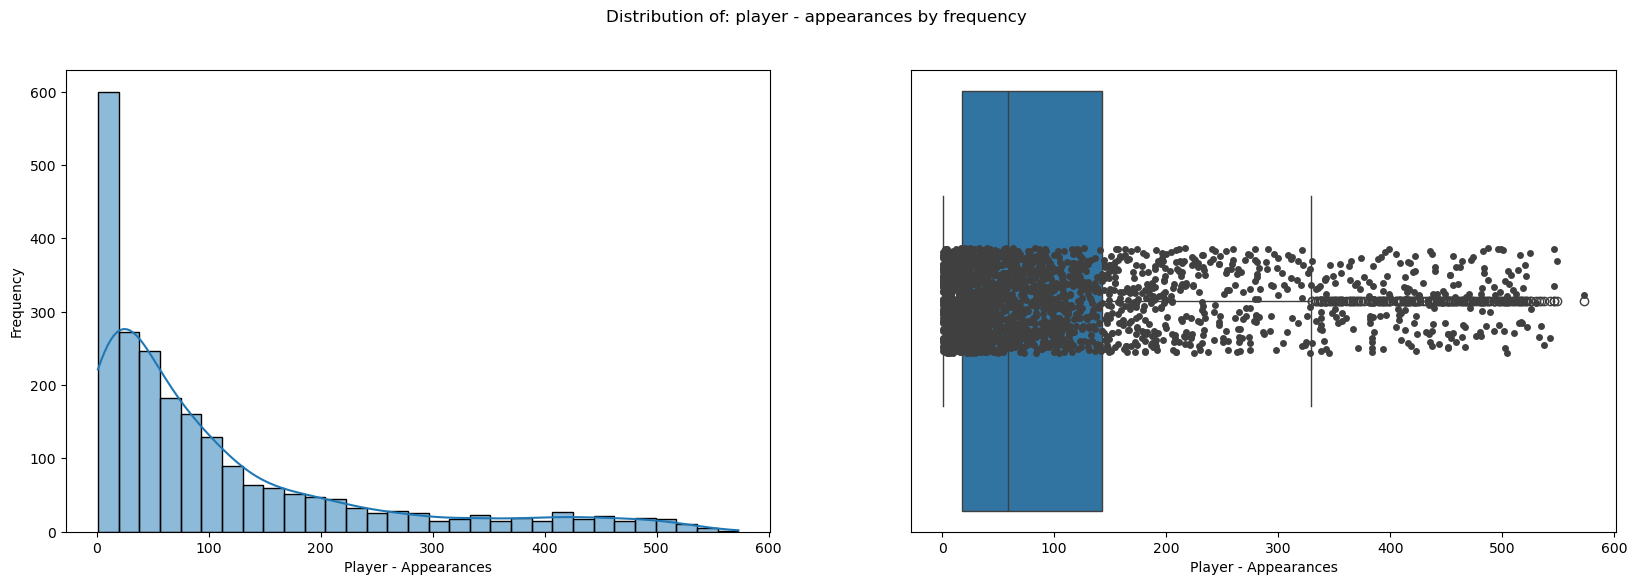

In [13]:
plot_distribution_by_variable(get_frequencies(cleaned_mlb_df, ["player_info__player_id"]), "frequency", "Player - Appearances", "Frequency")

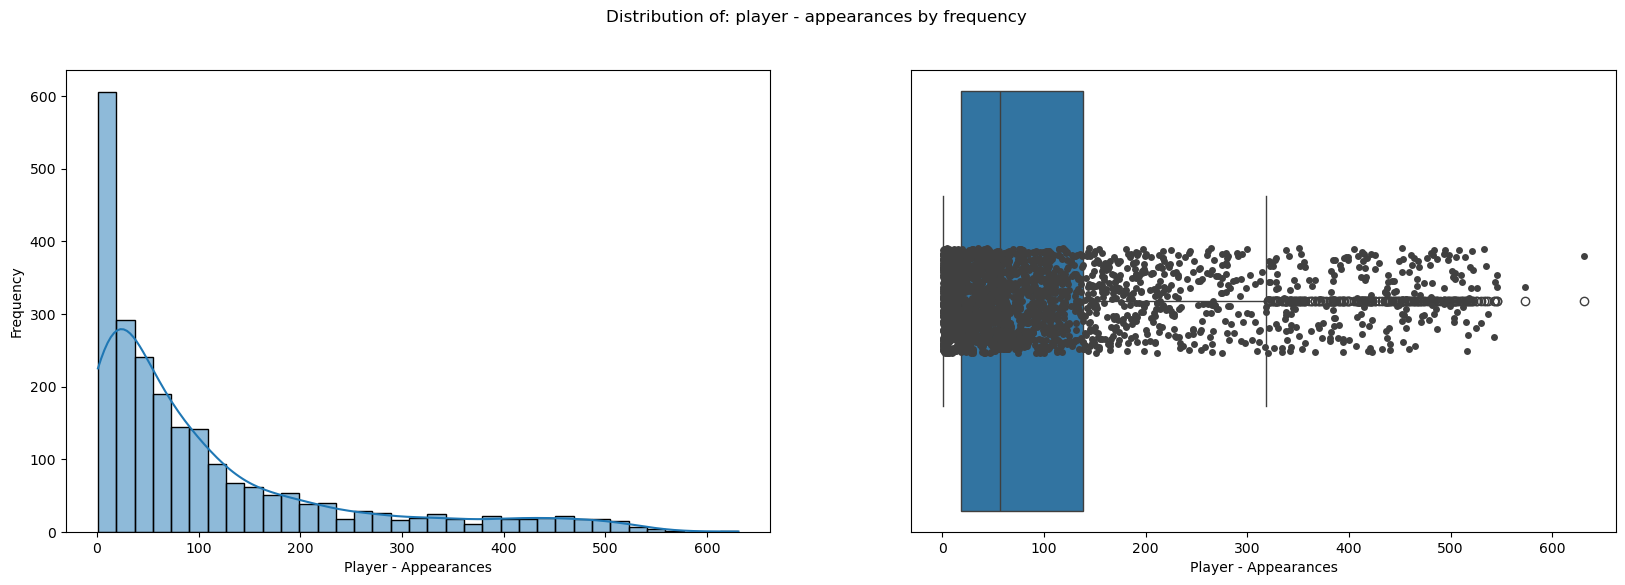

In [14]:
plot_distribution_by_variable(get_frequencies(cleaned_mlb_df, ["player_info__player_name"]), "frequency", "Player - Appearances", "Frequency")

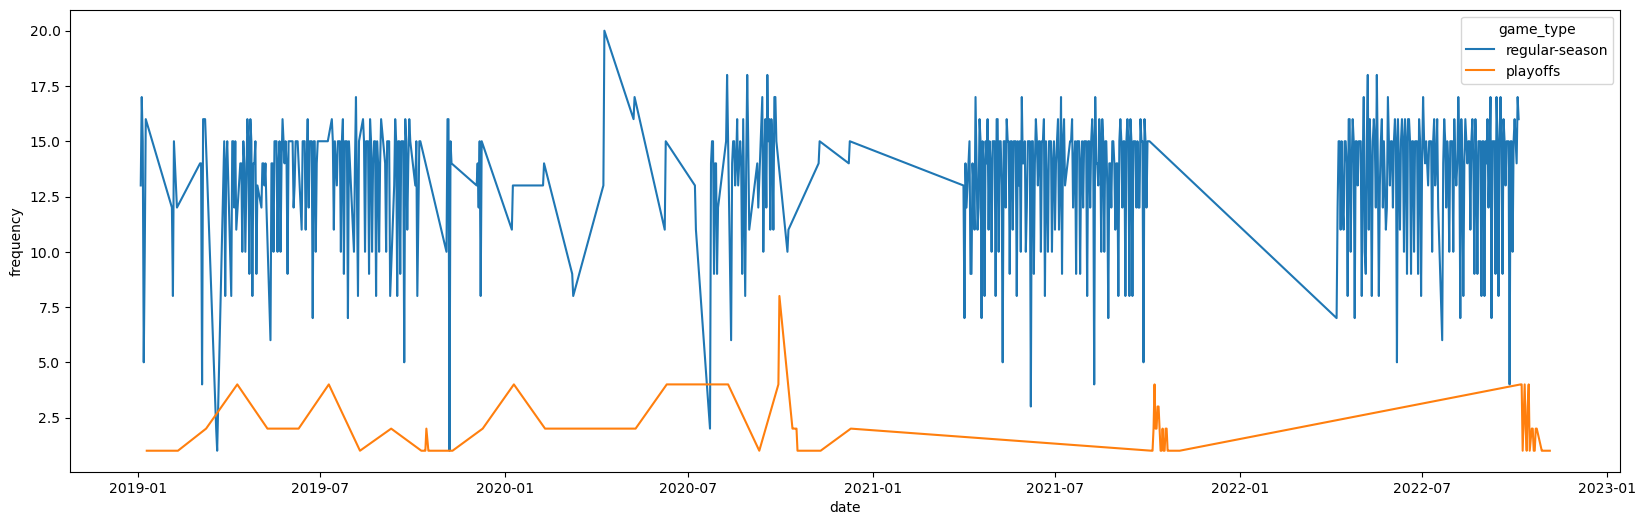

In [15]:
games_per_date = cleaned_mlb_df[["game_info__game_type", "game_info__game_id", "game_info__date"]].drop_duplicates()\
.groupby(["game_info__date", "game_info__game_type"])\
.size()\
.reset_index(name='frequency')\
.rename(columns={"game_info__date": "date", "game_info__game_type": "game_type"})

fig, ax = plt.subplots(figsize=(20, 6))

sns.lineplot(
    data=games_per_date,
    x="date",
    y="frequency",
    hue="game_type",
    ax=ax
)

plt.plot();

In [16]:
def plot_histogram(
    df: pd.DataFrame, 
    filter_column: str, 
    factor: Any, 
    value: str,
    kde: bool = False
) -> Figure:
    fig, ax = plt.subplots(ncols=1, figsize=(16, 8))

    sns.histplot(
        data=df[
        (df[filter_column] == factor) & (~df[value].isna())
        ], 
        x=value, 
        kde=kde,
        bins=100
    )
    ax.set_ylabel('Frecuency')
    ax.set_xlabel(" - ".join(value.split("__")))

    fig.suptitle(f'Distribution of: {value} by factor: {factor}')

    return fig

## Position

In [17]:
get_frequencies(cleaned_mlb_df, ["position__fanduel"]).sort_values(by=["frequency"], ascending=False).reset_index(drop=True)

,position__fanduel,frequency
0,P,69587
1,OF,58807
2,C,19887
3,1B,17444
4,SS,15615
5,3B,15597
6,2B,14718
7,2B/SS,4035
8,2B/OF,2877
9,3B/2B,2163


# Distributions fitting process

## P - Pitchers

In [18]:
cleaned_mlb_df.head()

,game_info__bigdataball_dataset,game_info__game_id,game_info__date,player_info__player_id,player_info__player_name,player_info__team,player_info__opponent,player_info__venue,position__draftkings,position__fanduel,position__yahoo,salary__draftkings,salary__fanduel,salary__yahoo,fantasy_points__draftkings,fantasy_points__fanduel,fantasy_points__yahoo,game_info__game_type,year
0,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,543939.0,Kolten Wong,Milwaukee Brewers,Chicago Cubs,Road,NaN,2B,NaN,NaN,2600.0,NaN,NaN,6.2,NaN,regular-season,2022
1,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,642715.0,Willy Adames,Milwaukee Brewers,Chicago Cubs,Road,NaN,SS,NaN,NaN,2900.0,NaN,NaN,12.5,NaN,regular-season,2022
2,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,592885.0,Christian Yelich,Milwaukee Brewers,Chicago Cubs,Road,NaN,OF,NaN,NaN,3300.0,NaN,NaN,6.5,NaN,regular-season,2022
3,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,457705.0,Andrew McCutchen,Milwaukee Brewers,Chicago Cubs,Road,NaN,OF,NaN,NaN,2500.0,NaN,NaN,12.2,NaN,regular-season,2022
4,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,642133.0,Rowdy Tellez,Milwaukee Brewers,Chicago Cubs,Road,NaN,C1B,NaN,NaN,2200.0,NaN,NaN,9.2,NaN,regular-season,2022


In [19]:
pitchers_df = cleaned_mlb_df[
    (cleaned_mlb_df.position__fanduel == "P") & 
    (~cleaned_mlb_df['fantasy_points__fanduel'].isna())
    ]

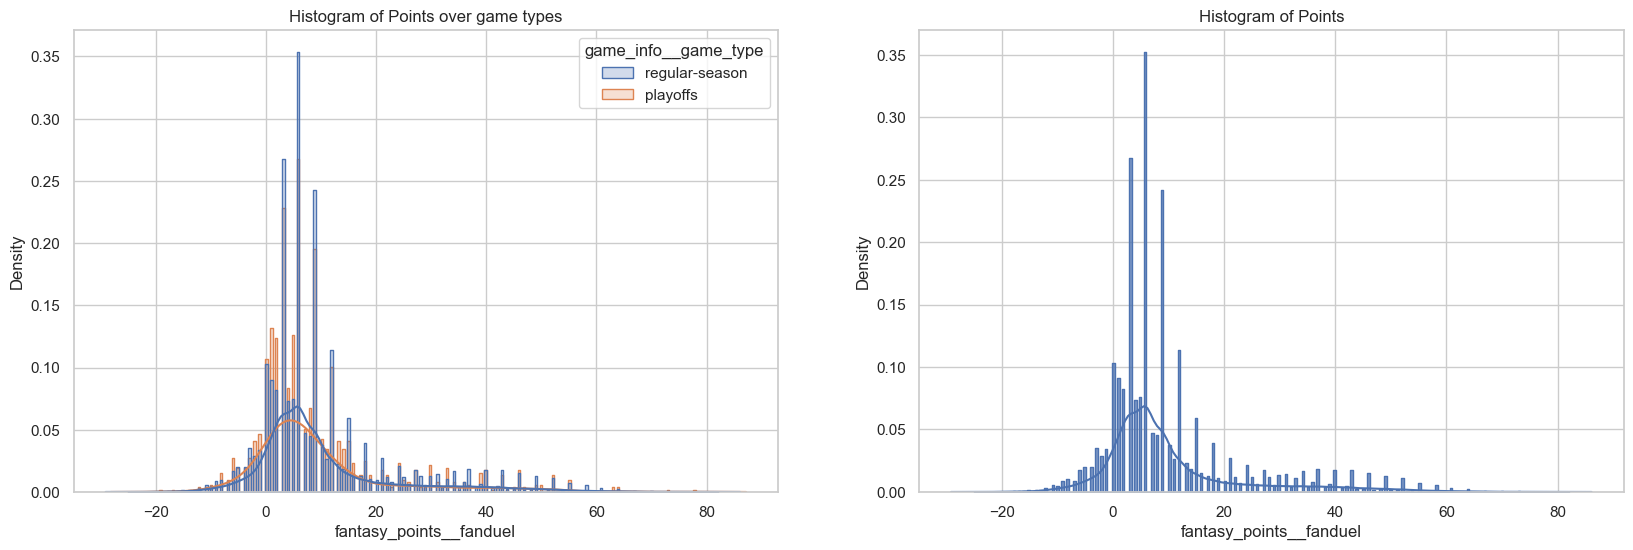

In [20]:
# Setting up style for better visualization
sns.set(style="whitegrid")

# Plotting the histogram
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))

sns.kdeplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    hue='game_info__game_type', 
    common_norm=False,
    ax=ax[0]
)

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    hue='game_info__game_type', 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=ax[0]
)

ax[0].set_title("Histogram of Points over game types")

sns.kdeplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel',  
    common_norm=False,
    ax=ax[1]
)

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=ax[1]
)

ax[1].set_title('Histogram of Points')

plt.show()

### Adding more variables for categorizing players and don't assume a general distribution

In [21]:
statistics_by_pitcher = pitchers_df\
.groupby('player_info__player_id')\
.agg(number_of_observations=pd.NamedAgg("player_info__player_id", "count"))\
.sort_values(by=['number_of_observations'])\
.pipe(lambda df: df.assign(
    cumsum_observations=df.number_of_observations.cumsum(), 
    total_observations=df.number_of_observations.sum()
))\
.pipe(lambda df: df.assign(
    cumulative_proportion=(df.cumsum_observations / df.total_observations) * 100))\
.reset_index()\
.pipe(lambda df: df.assign(
    decile_group=pd.cut(df.cumulative_proportion, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype("str")
))

In [22]:
pitchers_df = pitchers_df.merge(right=statistics_by_pitcher)

In [23]:
pitchers_df.head()

,game_info__bigdataball_dataset,game_info__game_id,game_info__date,player_info__player_id,player_info__player_name,player_info__team,player_info__opponent,player_info__venue,position__draftkings,position__fanduel,...,fantasy_points__draftkings,fantasy_points__fanduel,fantasy_points__yahoo,game_info__game_type,year,number_of_observations,cumsum_observations,total_observations,cumulative_proportion,decile_group
0,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,669203.0,Corbin Burnes,Milwaukee Brewers,Chicago Cubs,Road,NaN,P,...,NaN,18.0,NaN,regular-season,2022,105,40565,69587,58.293934,"(50, 60]"
1,MLB 2022 Regular Season,44664-MIL@BAL-1,2022-04-13,669203.0,Corbin Burnes,Milwaukee Brewers,Baltimore Orioles,Road,NaN,P,...,NaN,49.0,32.5,regular-season,2022,105,40565,69587,58.293934,"(50, 60]"
2,MLB 2022 Regular Season,44670-PIT@MIL-1,2022-04-19,669203.0,Corbin Burnes,Milwaukee Brewers,Pittsburgh Pirates,Home,P,P,...,33.35,55.0,37.4,regular-season,2022,105,40565,69587,58.293934,"(50, 60]"
3,MLB 2022 Regular Season,44676-SFG@MIL-1,2022-04-25,669203.0,Corbin Burnes,Milwaukee Brewers,San Francisco Giants,Home,P,P,...,34.00,57.0,NaN,regular-season,2022,105,40565,69587,58.293934,"(50, 60]"
4,MLB 2022 Regular Season,44682-CHC@MIL-1,2022-05-01,669203.0,Corbin Burnes,Milwaukee Brewers,Chicago Cubs,Home,P,P,...,28.75,49.0,32.5,regular-season,2022,105,40565,69587,58.293934,"(50, 60]"


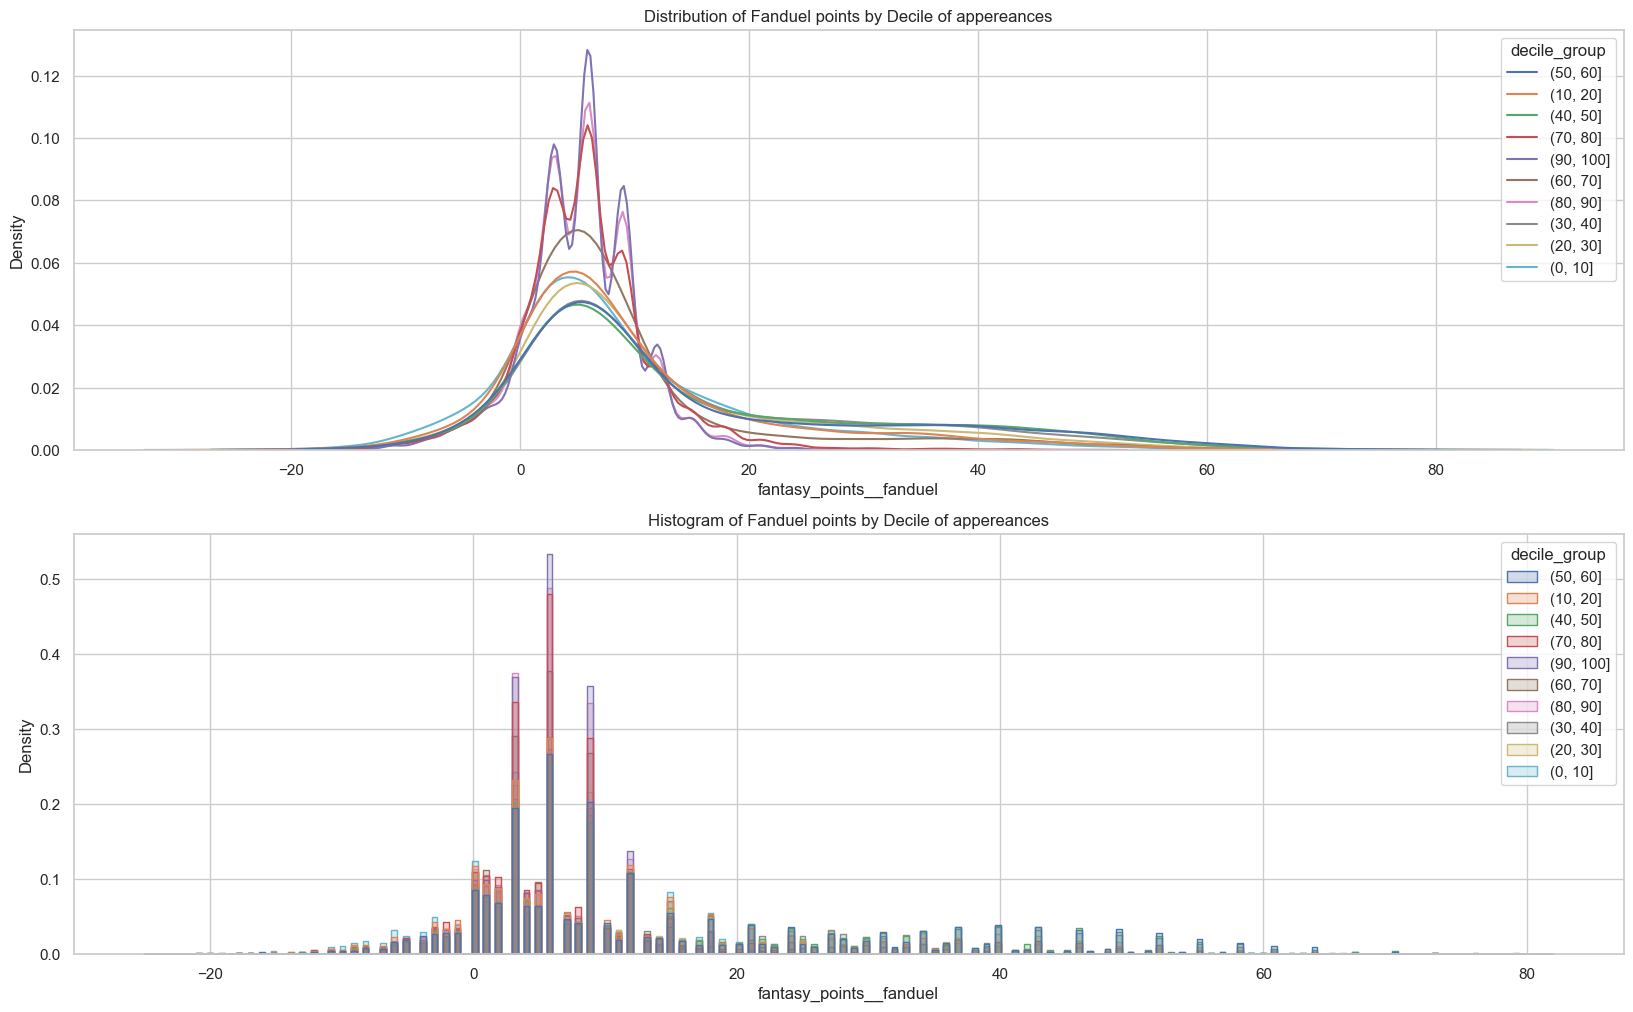

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 12))

sns.kdeplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    hue='decile_group', 
    common_norm=False,
    ax=ax[0],
)

ax[0].set_title('Distribution of Fanduel points by Decile of appereances')

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    hue='decile_group', 
    common_norm=False, # Helps on visualization,
    ax=ax[1]
)

ax[1].set_title('Histogram of Fanduel points by Decile of appereances')

plt.show()

### Fitting a general distribution for all the population of pitchers

#### Fitting

In [34]:
data = pitchers_df['fantasy_points__fanduel']

In [35]:
pitchers_distribution_fitter = DistributionFitter(
    distributions=[dist for dist in get_distributions() if dist not in ["levy_stable", "studentized_range", "erlang", "lognorm", "loguniform"]], 
    bins=sturges_bins(data)
)

In [36]:
pitchers_distribution_fitter.fit(data)

INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: alpha
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: anglit
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: arcsine
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: argus
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: beta
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: betaprime
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: bradford
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: burr
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: burr12
INFO:statistical_simulation_t

In [38]:
pitchers_distribution_fitter.summary(sort_by="ks_statistic", top_n=20)

,distribution,squared_error,aic,bic,kullberg_divergence,ks_statistic,ks_p_value,fitted_params
johnsonsu,johnsonsu,0.279654,3237.817601,3274.418934,inf,0.077089,0.0,"{'a': -0.7427241888177314, 'b': 0.872681705728..."
norminvgauss,norminvgauss,0.279139,3265.040498,3301.641831,inf,0.078111,0.0,"{'a': 0.5081836267007738, 'b': 0.3915655691558..."
nct,nct,0.279995,3265.547253,3302.148585,inf,0.080681,0.0,"{'df': 1.8321062249827091, 'nc': 1.20907318347..."
genhyperbolic,genhyperbolic,0.279457,3230.866132,3276.617797,inf,0.081184,0.0,"{'p': -0.009442170205702916, 'a': 0.3509869978..."
skewcauchy,skewcauchy,0.279372,3145.885595,3173.336594,inf,0.092572,0.0,"{'a': 0.44363369918345535, 'loc': 3.2209192815..."
loglaplace,loglaplace,0.277658,3472.183515,3499.634514,inf,0.108121,0.0,"{'c': 4.555453459282299, 'loc': -25.0372301810..."
t,t,0.280463,3319.723631,3347.174630,inf,0.109933,0.0,"{'df': 1.4680507180806637, 'loc': 5.9808390853..."
tukeylambda,tukeylambda,0.280360,3312.670860,3340.121859,inf,0.111245,0.0,"{'lam': -0.5621319691124701, 'loc': 5.96266076..."
burr,burr,0.287806,3777.436761,3814.038093,inf,0.115516,0.0,"{'c': 5.352801267512225, 'd': 1.95130585199655..."
laplace_asymmetric,laplace_asymmetric,0.281542,3381.880227,3409.331226,inf,0.115773,0.0,"{'kappa': 0.5858184617584932, 'loc': 2.9999999..."


#### Validation

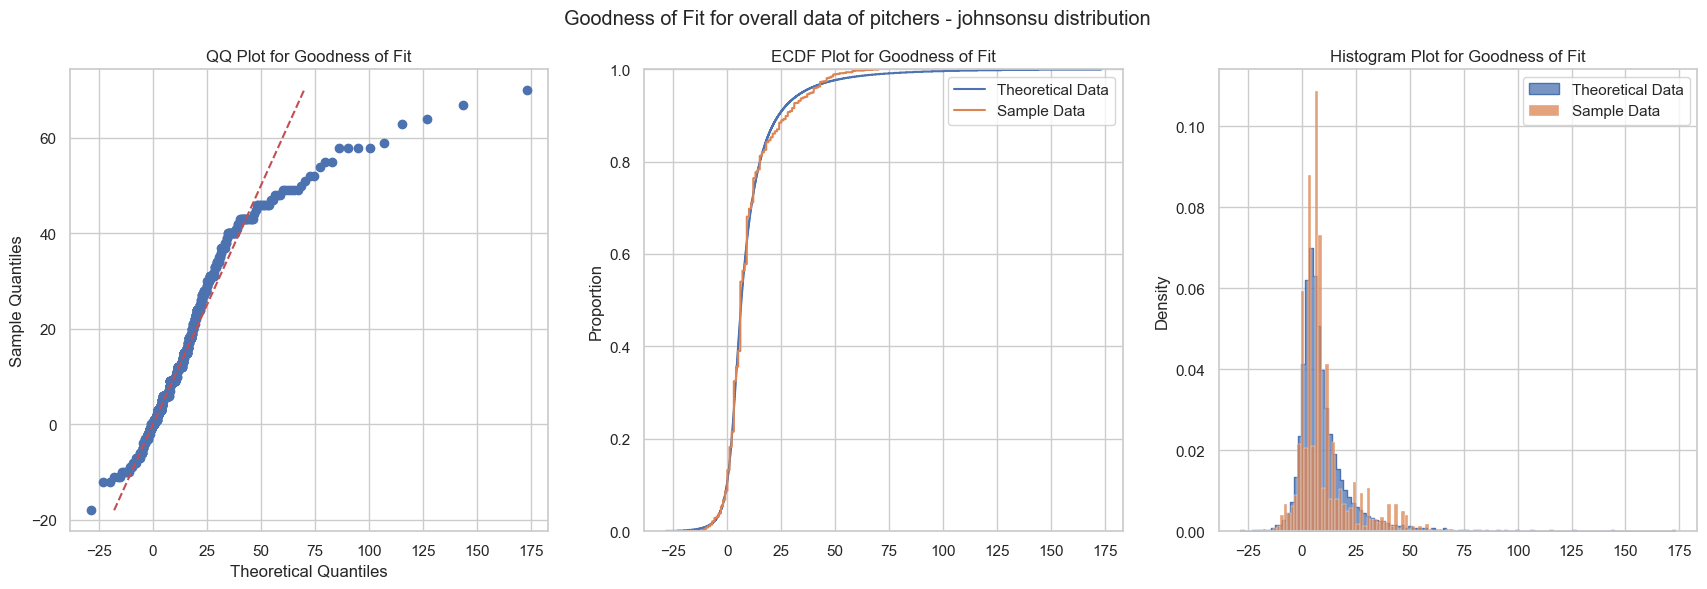

In [47]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="johnsonsu", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - johnsonsu distribution"
)

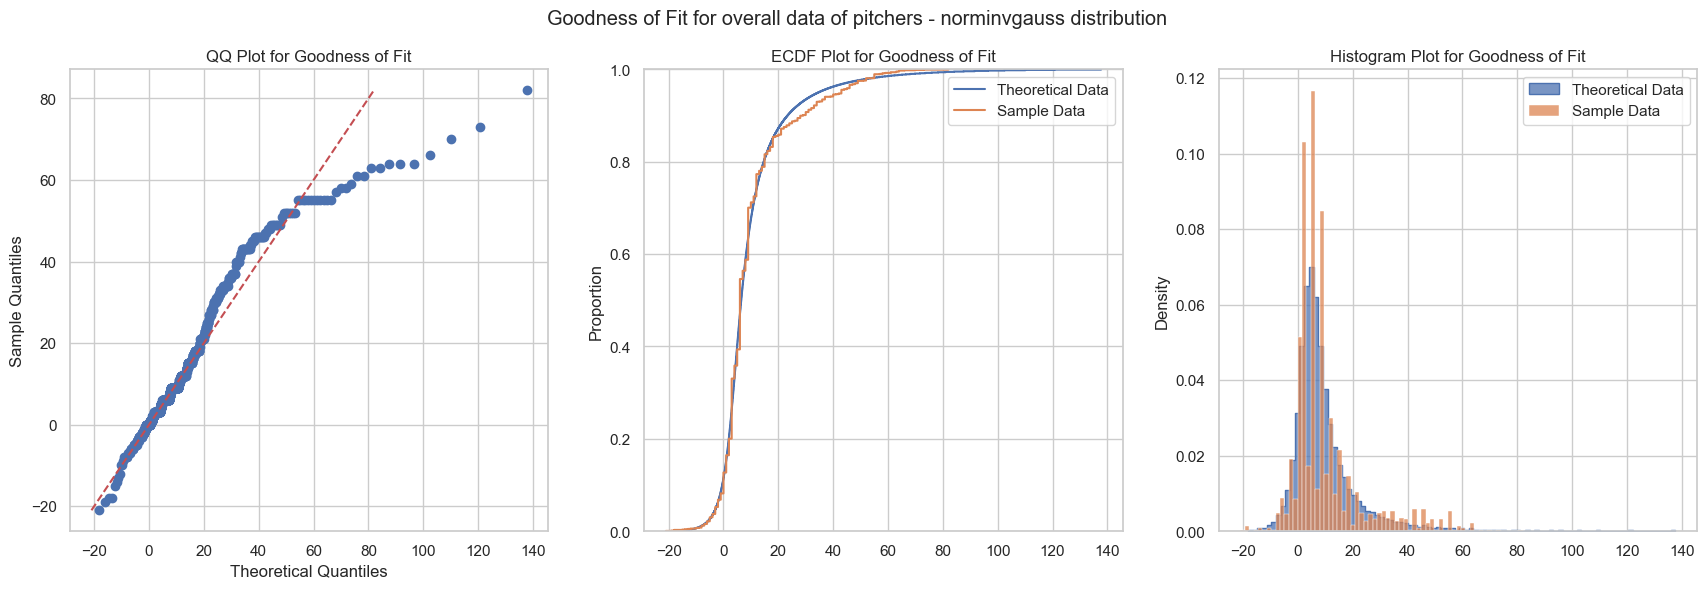

In [40]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="norminvgauss", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - norminvgauss distribution"
)

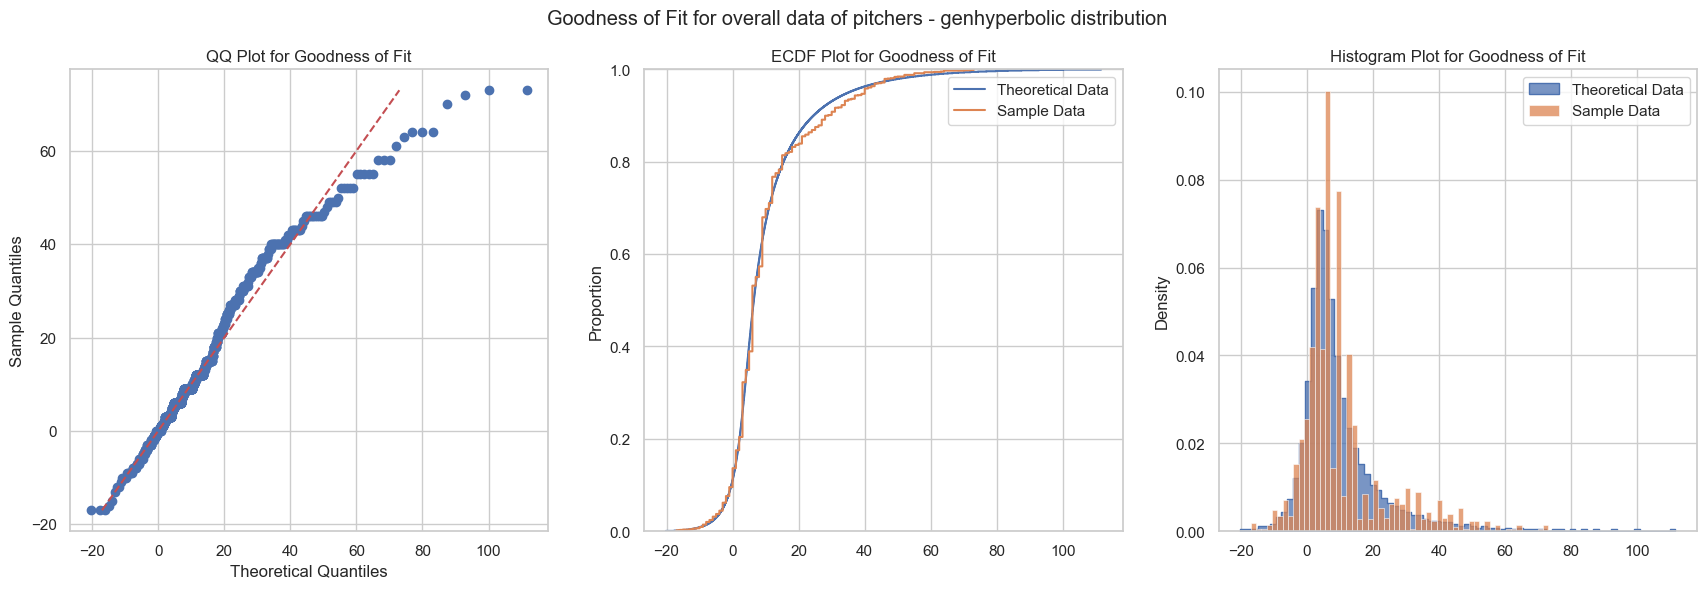

In [41]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="genhyperbolic", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - genhyperbolic distribution"
)

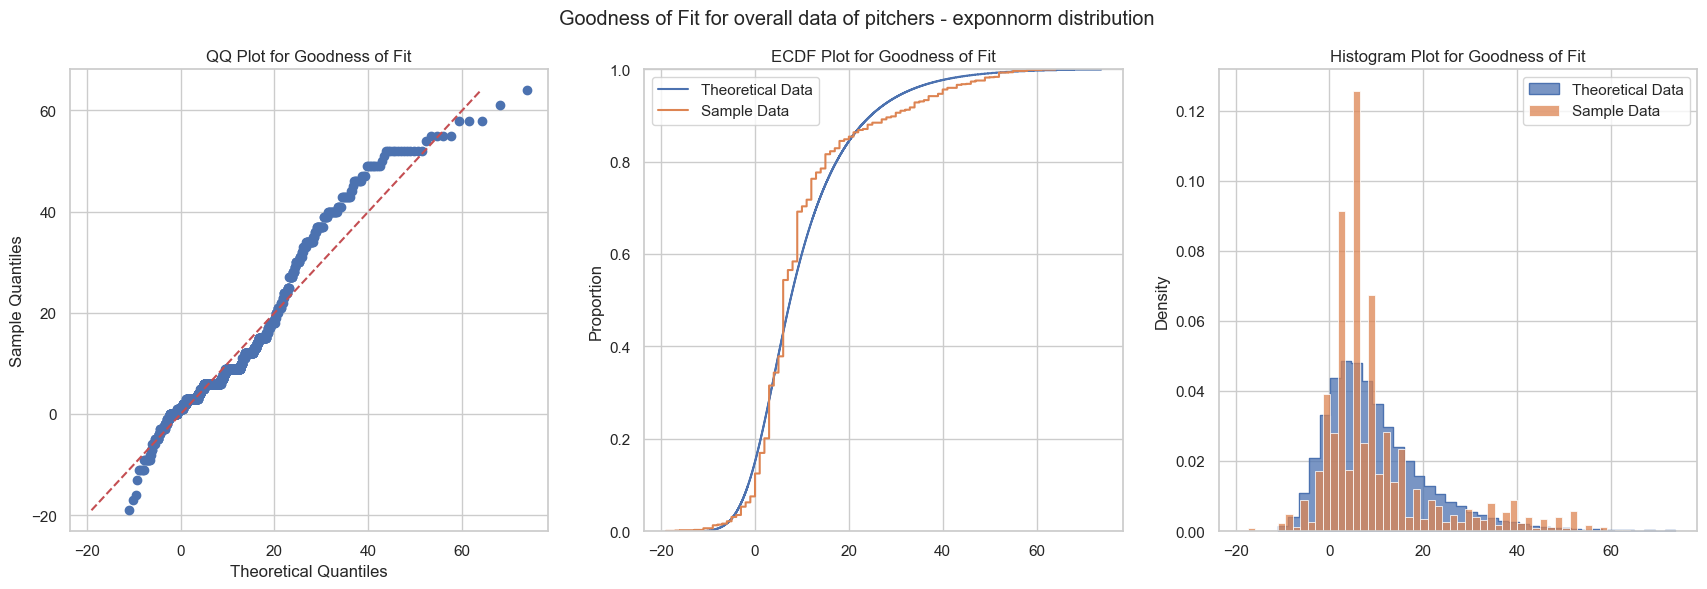

In [42]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="exponnorm", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - exponnorm distribution"
)

### Pitchers dataframe for distributions

In [43]:
pitchers_df.head()

,game_info__bigdataball_dataset,game_info__game_id,game_info__date,player_info__player_id,player_info__player_name,player_info__team,player_info__opponent,player_info__venue,position__draftkings,position__fanduel,...,fantasy_points__draftkings,fantasy_points__fanduel,fantasy_points__yahoo,game_info__game_type,year,number_of_observations,cumsum_observations,total_observations,cumulative_proportion,decile_group
0,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,669203.0,Corbin Burnes,Milwaukee Brewers,Chicago Cubs,Road,NaN,P,...,NaN,18.0,NaN,regular-season,2022,105,40565,69587,58.293934,"(50, 60]"
1,MLB 2022 Regular Season,44664-MIL@BAL-1,2022-04-13,669203.0,Corbin Burnes,Milwaukee Brewers,Baltimore Orioles,Road,NaN,P,...,NaN,49.0,32.5,regular-season,2022,105,40565,69587,58.293934,"(50, 60]"
2,MLB 2022 Regular Season,44670-PIT@MIL-1,2022-04-19,669203.0,Corbin Burnes,Milwaukee Brewers,Pittsburgh Pirates,Home,P,P,...,33.35,55.0,37.4,regular-season,2022,105,40565,69587,58.293934,"(50, 60]"
3,MLB 2022 Regular Season,44676-SFG@MIL-1,2022-04-25,669203.0,Corbin Burnes,Milwaukee Brewers,San Francisco Giants,Home,P,P,...,34.00,57.0,NaN,regular-season,2022,105,40565,69587,58.293934,"(50, 60]"
4,MLB 2022 Regular Season,44682-CHC@MIL-1,2022-05-01,669203.0,Corbin Burnes,Milwaukee Brewers,Chicago Cubs,Home,P,P,...,28.75,49.0,32.5,regular-season,2022,105,40565,69587,58.293934,"(50, 60]"


In [80]:
def fit_individual_distribution(
    df: pd.DataFrame, 
    factor: str, 
    variable: str, 
    distribution_name: str, 
    default_parameters: dict,
    minimum_number_of_observations: Optional[int] = None
) -> List[Dict]:

    factor_levels = df[factor].unique().tolist()
    distribution: rv_continuous = getattr(scipy.stats, distribution_name)

    minimum_number_of_observations = minimum_number_of_observations if minimum_number_of_observations is not None else 0

    fitted_distributions = []

    for factor_level in factor_levels:
        data = df[df[factor] == factor_level][variable].to_numpy()

        number_observations = len(data)
        if number_observations > minimum_number_of_observations:
            parameters_names = (
                    (distribution.shapes + ", loc, scale").split(", ")
                    if distribution.shapes
                    else ["loc", "scale"]
                )
            estimated_parameters = distribution.fit(data=data)
            response = {"factor_level": factor_level, "distribution": distribution_name, "parameters": {
                param_k: param_v for param_k, param_v in zip(parameters_names, estimated_parameters)
            }}
        else:
            response = {"factor_level": factor_level, "distribution": distribution_name, "parameters": default_parameters}

        fitted_distributions.append(response)

    return fitted_distributions

In [81]:
pitchers_fitted_distributions = fit_individual_distribution(
    df=pitchers_df, 
    factor="player_info__player_id", 
    variable="fantasy_points__fanduel", 
    distribution_name="exponnorm", 
    default_parameters=pitchers_distribution_fitter.get_distribution_parameters("exponnorm"), 
    minimum_number_of_observations=30
)

In [99]:
pitchers_distributions_df = pd.DataFrame(pitchers_fitted_distributions)\
.rename(columns={"factor_level": "player_info__player_id"})\
.assign(position__fanduel="P")

In [167]:
pitchers_distributions_df.shape

(1257, 4)

In [169]:
pitchers_distributions_df.head().to_dict(orient="records")

[{'player_info__player_id': 669203.0,
  'distribution': 'exponnorm',
  'parameters': {'K': 0.22090172328268076,
   'loc': 24.525045286425026,
   'scale': 20.990613765036827},
  'position__fanduel': 'P'},
 {'player_info__player_id': 676879.0,
  'distribution': 'exponnorm',
  'parameters': {'K': 0.12663299882285745,
   'loc': 15.419435099146202,
   'scale': 11.889193982564032},
  'position__fanduel': 'P'},
 {'player_info__player_id': 664776.0,
  'distribution': 'exponnorm',
  'parameters': {'K': 0.0010424341108567921,
   'loc': 6.848669556872749,
   'scale': 4.8062882301355305},
  'position__fanduel': 'P'},
 {'player_info__player_id': 543294.0,
  'distribution': 'exponnorm',
  'parameters': {'K': 0.0011764958898237738,
   'loc': 27.15682371284536,
   'scale': 17.87146682109281},
  'position__fanduel': 'P'},
 {'player_info__player_id': 596057.0,
  'distribution': 'exponnorm',
  'parameters': {'K': 1.7953384915413375,
   'loc': 0.5757283559412238,
   'scale': 4.716532014445237},
  'positio

In [171]:
player_distribution = scipy.stats.exponnorm(**{'K': 0.22090172328268076,
   'loc': 24.525045286425026,
   'scale': 20.990613765036827})

In [172]:
player_distribution.rvs()

17.065585480901582

## OF - Outfield

In [85]:
outfield_df = cleaned_mlb_df[
    (cleaned_mlb_df.position__fanduel == "OF") & 
    (~cleaned_mlb_df['fantasy_points__fanduel'].isna())
    ]

In [86]:
outfield_df.size

1117333

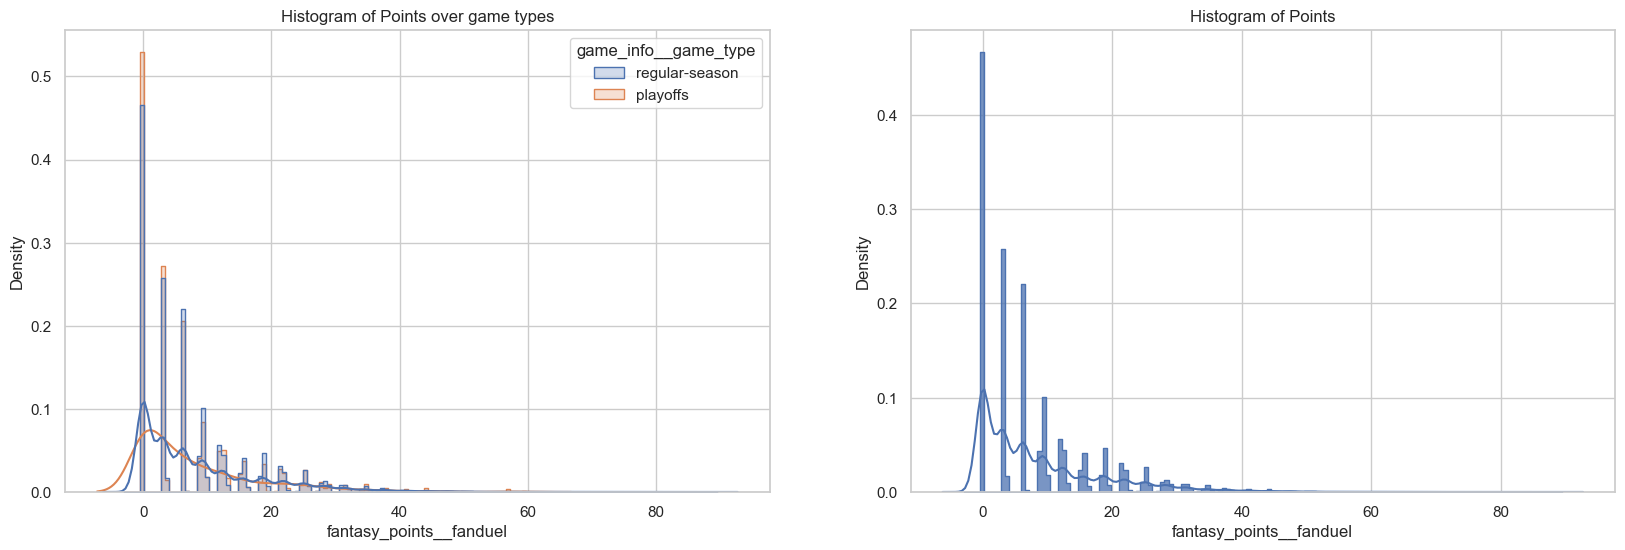

In [87]:
# Setting up style for better visualization
sns.set(style="whitegrid")

# Plotting the histogram
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))

sns.kdeplot(
    data=outfield_df, 
    x='fantasy_points__fanduel', 
    hue='game_info__game_type', 
    common_norm=False,
    ax=ax[0]
)

sns.histplot(
    data=outfield_df, 
    x='fantasy_points__fanduel', 
    hue='game_info__game_type', 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=ax[0]
)

ax[0].set_title("Histogram of Points over game types")

sns.kdeplot(
    data=outfield_df, 
    x='fantasy_points__fanduel',  
    common_norm=False,
    ax=ax[1]
)

sns.histplot(
    data=outfield_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=ax[1]
)

ax[1].set_title('Histogram of Points')

plt.show()

In [89]:
statistics_by_outfield = outfield_df\
.groupby('player_info__player_id')\
.agg(number_of_observations=pd.NamedAgg("player_info__player_id", "count"))\
.sort_values(by=['number_of_observations'])\
.pipe(lambda df: df.assign(
    cumsum_observations=df.number_of_observations.cumsum(), 
    total_observations=df.number_of_observations.sum()
))\
.pipe(lambda df: df.assign(
    cumulative_proportion=(df.cumsum_observations / df.total_observations) * 100))\
.reset_index()\
.pipe(lambda df: df.assign(
    decile_group=pd.cut(df.cumulative_proportion, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype("str")
))

In [94]:
outfield_df = outfield_df.merge(statistics_by_outfield)

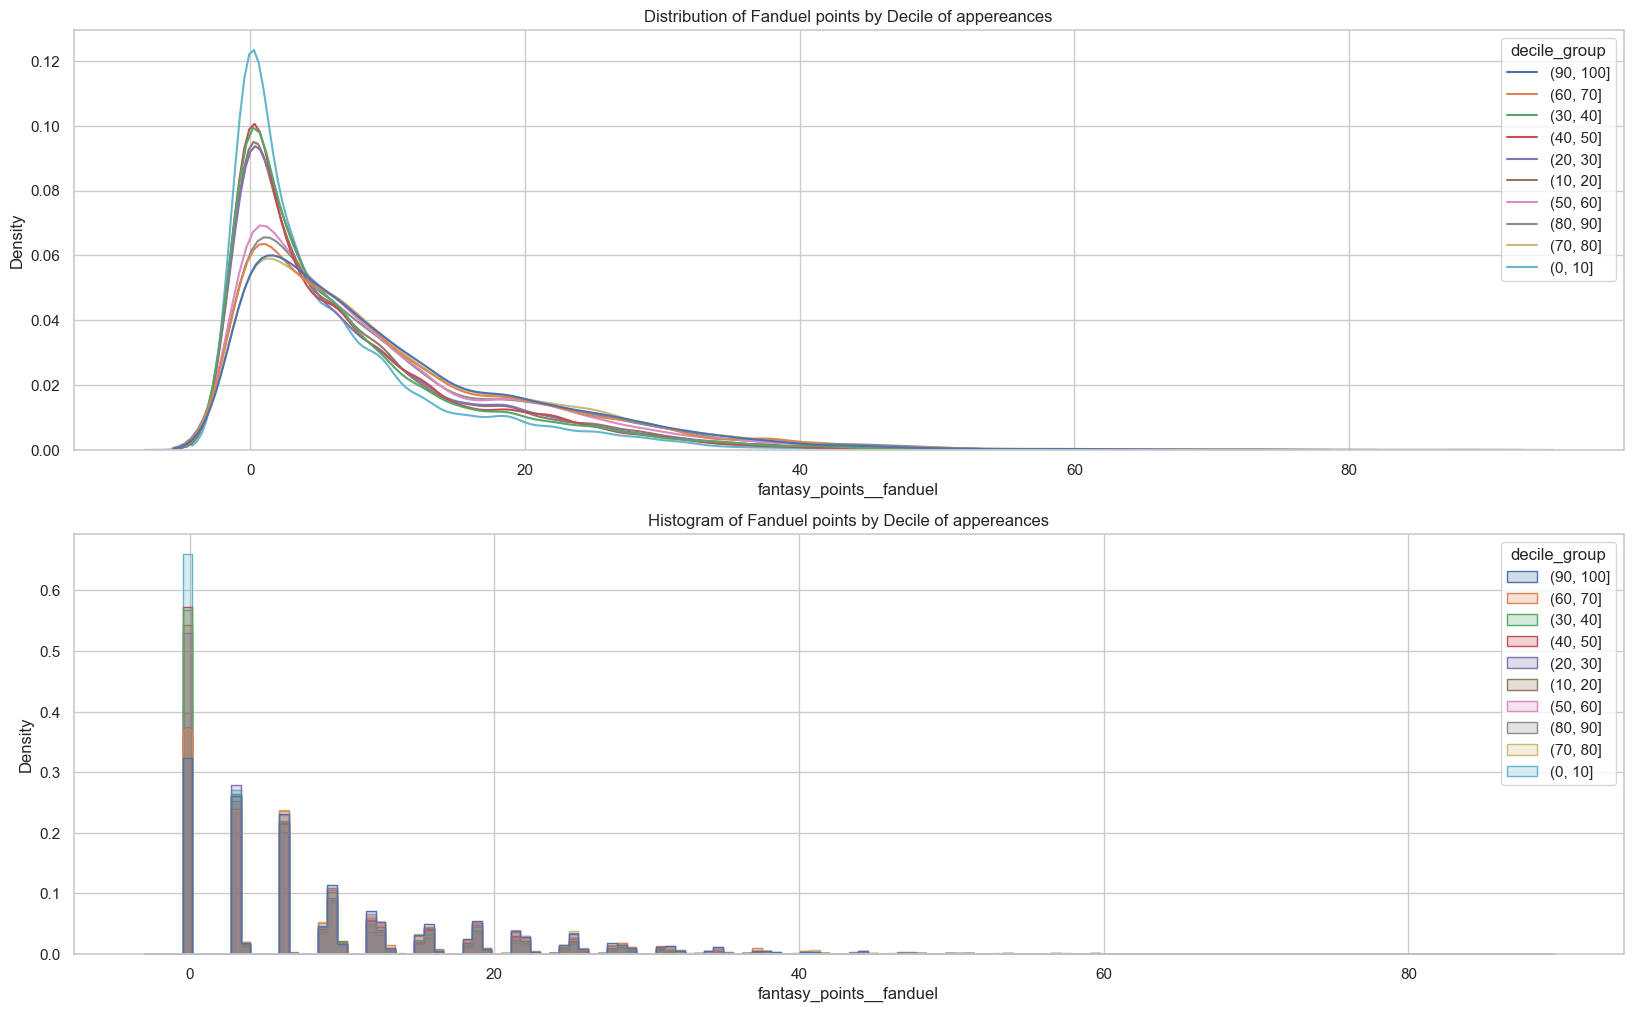

In [95]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 12))

sns.kdeplot(
    data=outfield_df, 
    x='fantasy_points__fanduel', 
    hue='decile_group', 
    common_norm=False,
    ax=ax[0],
)

ax[0].set_title('Distribution of Fanduel points by Decile of appereances')

sns.histplot(
    data=outfield_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    hue='decile_group', 
    common_norm=False, # Helps on visualization,
    ax=ax[1]
)

ax[1].set_title('Histogram of Fanduel points by Decile of appereances')

plt.show()

### Fitting a general distribution

In [96]:
data = outfield_df['fantasy_points__fanduel']

#### Fitting

In [97]:
outfield_distribution_fitter = DistributionFitter(
    distributions=[dist for dist in get_distributions() if dist not in ["levy_stable", "studentized_range", "erlang", "lognorm", "loguniform"]], 
    bins=sturges_bins(data)
)

In [98]:
outfield_distribution_fitter.fit(data)

INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: alpha
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: anglit
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: arcsine
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: argus
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: beta
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: betaprime
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: bradford
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: burr
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: burr12
INFO:statistical_simulation_t

#### Results

In [101]:
outfield_distribution_fitter.summary(sort_by="ks_statistic", top_n=15)

,distribution,squared_error,aic,bic,kullberg_divergence,ks_statistic,ks_p_value,fitted_params
nakagami,nakagami,0.784411,4592.509980,4619.456029,inf,0.149433,0.0,"{'nu': 0.5212580306386961, 'loc': -3.000015922..."
chi,chi,0.784411,4592.518641,4619.464690,inf,0.149434,0.0,"{'df': 1.0425184745730376, 'loc': -3.000015773..."
truncnorm,truncnorm,0.784858,5354.930406,5390.858471,inf,0.153580,0.0,"{'a': -0.28186912299728095, 'b': 44.3302422939..."
genhalflogistic,genhalflogistic,0.784716,4771.424943,4798.370992,inf,0.154395,0.0,"{'c': 0.10441162285276673, 'loc': -3.000000340..."
gibrat,gibrat,0.759636,2896.511527,2914.475560,inf,0.157284,0.0,"{'loc': -3.001723840453023, 'scale': 8.2054518..."
foldnorm,foldnorm,0.785006,4497.889461,4524.835510,inf,0.158106,0.0,"{'c': 0.06270420441166503, 'loc': -3.000000001..."
halfnorm,halfnorm,0.784988,4500.112420,4518.076452,inf,0.158227,0.0,"{'loc': -3.000000000808708, 'scale': 15.026432..."
genlogistic,genlogistic,0.787315,4062.598451,4089.544500,inf,0.163445,0.0,"{'c': 1798.9977634821344, 'loc': -41.867387743..."
gumbel_r,gumbel_r,0.787361,4060.564303,4078.528335,inf,0.163851,0.0,"{'loc': 4.355773850172532, 'scale': 6.16576138..."
rel_breitwigner,rel_breitwigner,0.783562,3223.469545,3250.415593,inf,0.165310,0.0,"{'rho': 0.0017110809634040486, 'loc': -3.00031..."


#### Validation

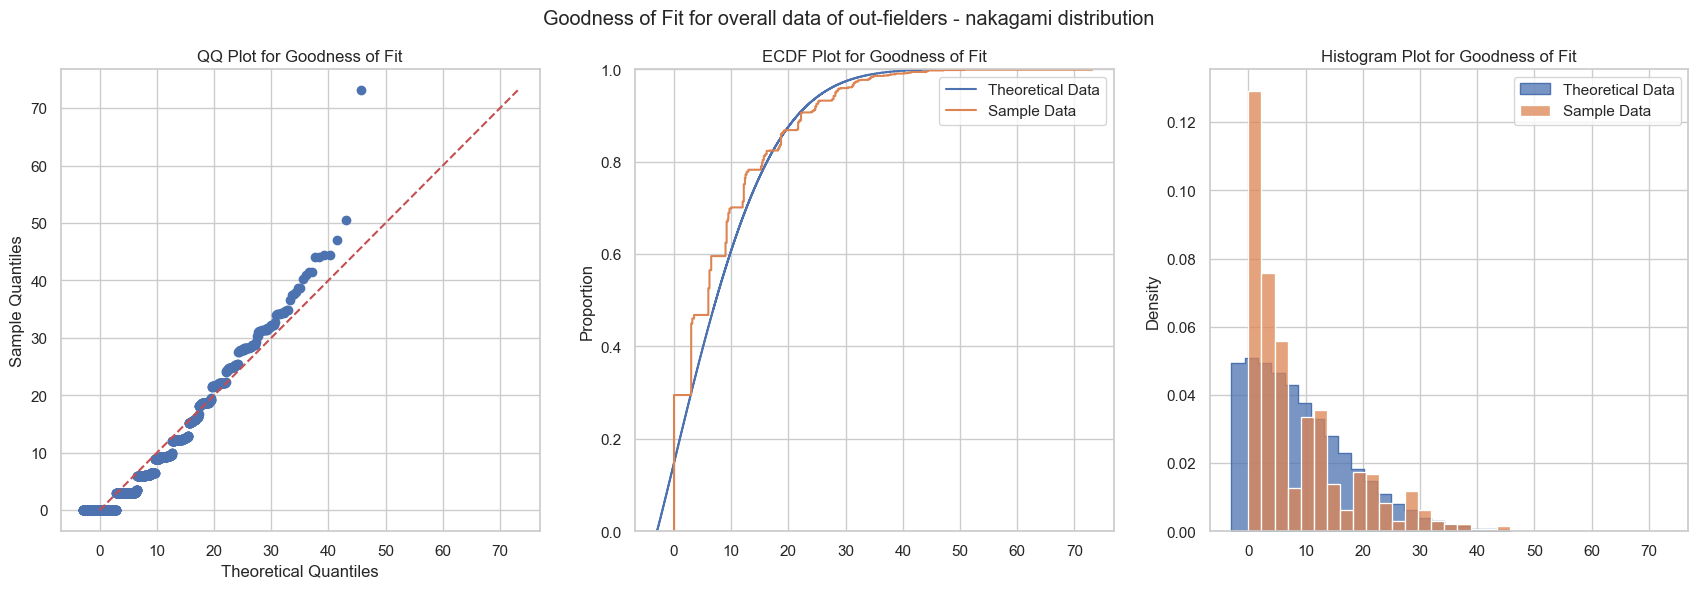

In [102]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=outfield_distribution_fitter, 
    distribution_name="nakagami", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - nakagami distribution"
)

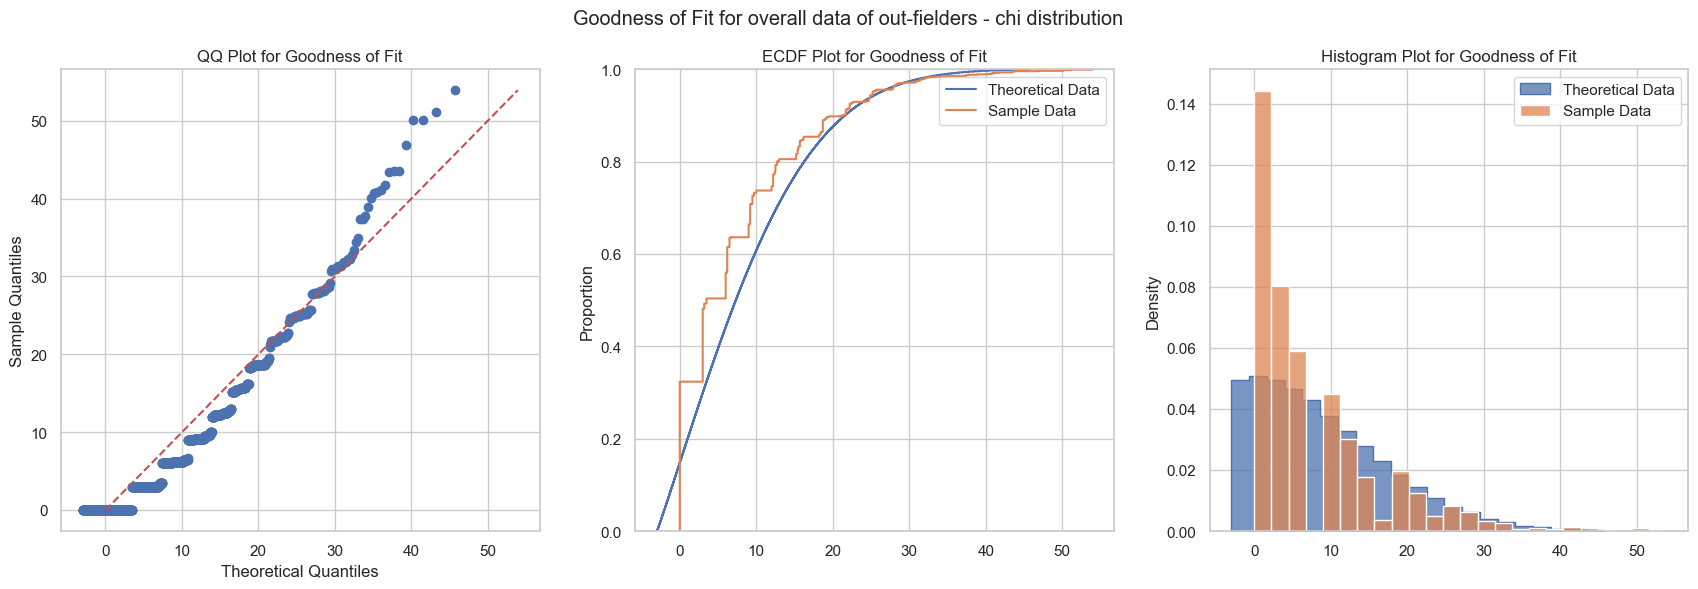

In [103]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=outfield_distribution_fitter, 
    distribution_name="chi", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - chi distribution"
)

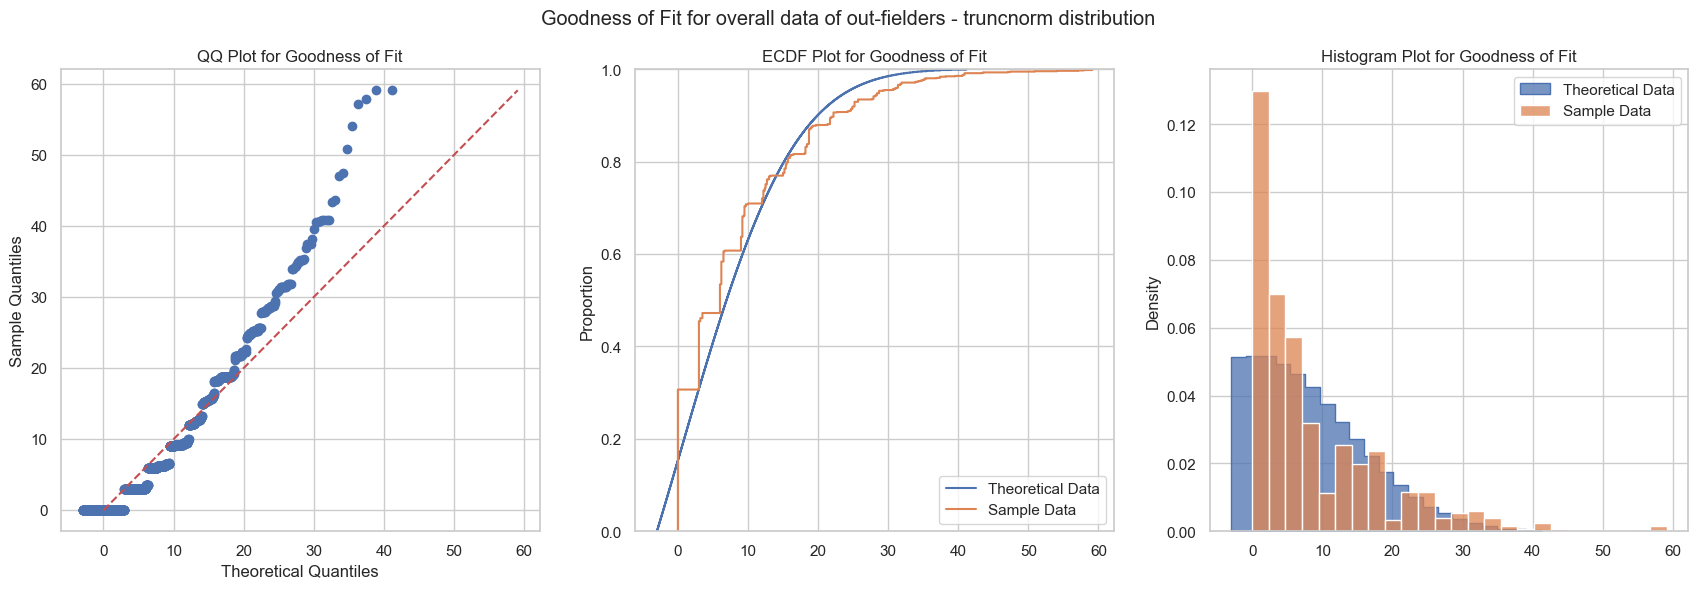

In [104]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=outfield_distribution_fitter, 
    distribution_name="truncnorm", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - truncnorm distribution"
)

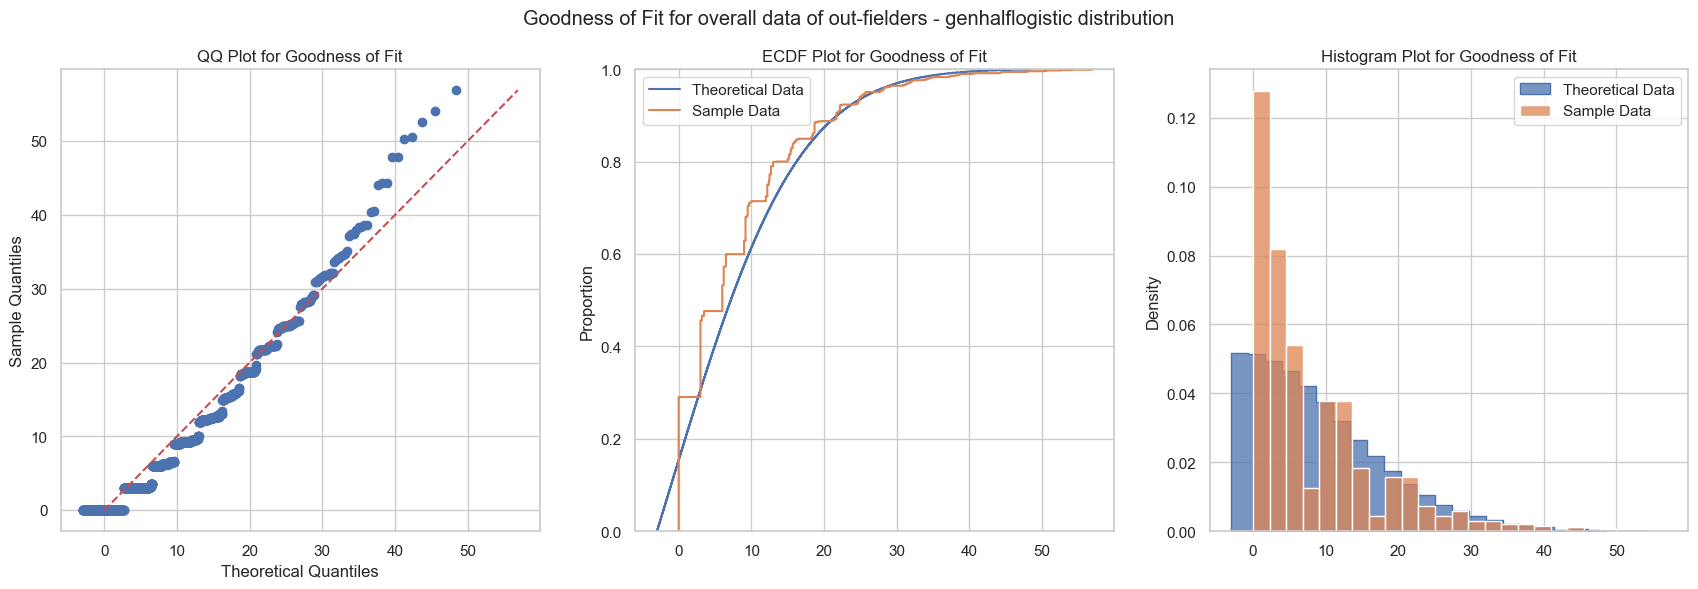

In [105]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=outfield_distribution_fitter, 
    distribution_name="genhalflogistic", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - genhalflogistic distribution"
)

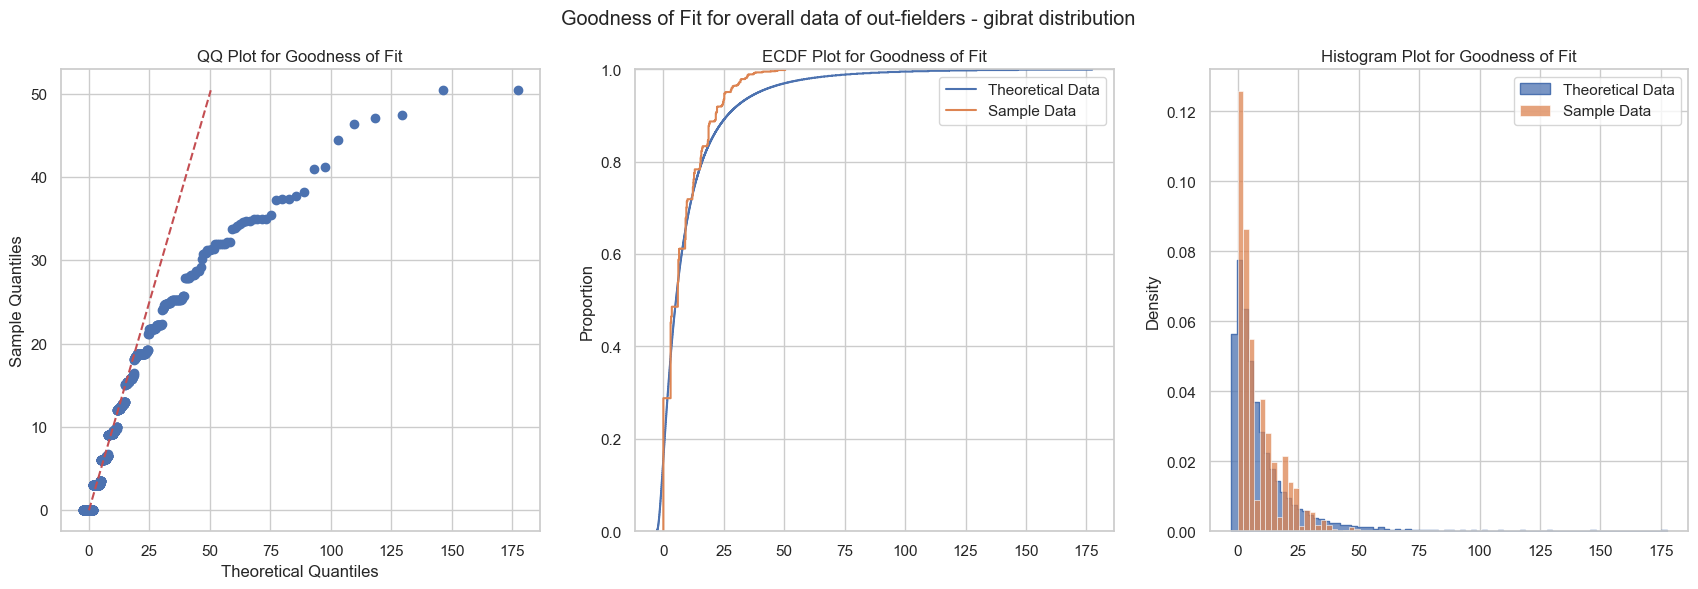

In [106]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=outfield_distribution_fitter, 
    distribution_name="gibrat", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - gibrat distribution"
)

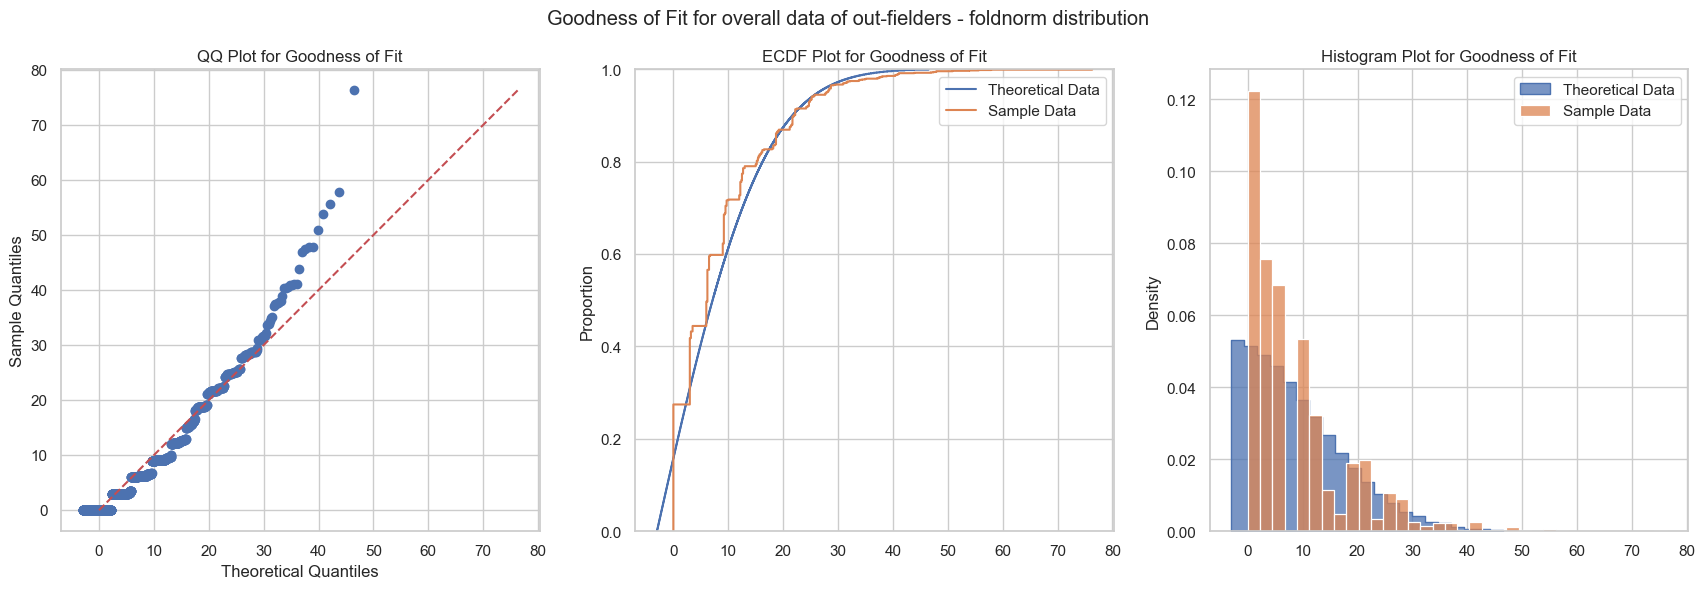

In [107]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=outfield_distribution_fitter, 
    distribution_name="foldnorm", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - foldnorm distribution"
)

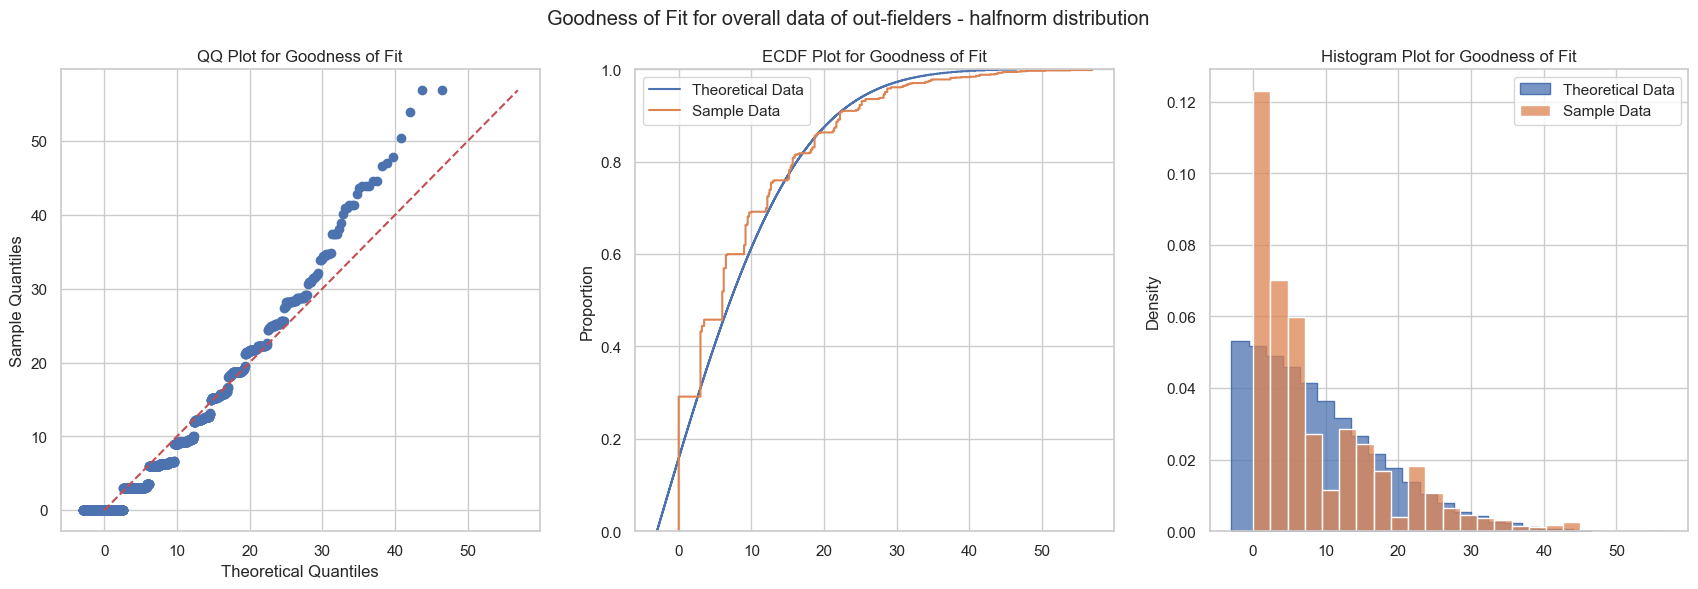

In [108]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=outfield_distribution_fitter, 
    distribution_name="halfnorm", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - halfnorm distribution"
)

### Outfilders dataframe for distributions

In [109]:
outfilders_fitted_distributions = fit_individual_distribution(
    df=outfield_df, 
    factor="player_info__player_id", 
    variable="fantasy_points__fanduel", 
    distribution_name="nakagami", 
    default_parameters=pitchers_distribution_fitter.get_distribution_parameters("nakagami"), 
    minimum_number_of_observations=30
)

In [110]:
outfilders_distributions_df = pd.DataFrame(outfilders_fitted_distributions)\
.rename(columns={"factor_level": "player_info__player_id"})\
.assign(position__fanduel="OF")

## C - Catcher

In [131]:
catchers_df = cleaned_mlb_df[
    (cleaned_mlb_df.position__fanduel == "C") & 
    (~cleaned_mlb_df['fantasy_points__fanduel'].isna()) &
    (cleaned_mlb_df['fantasy_points__fanduel'] > 0)
    ]

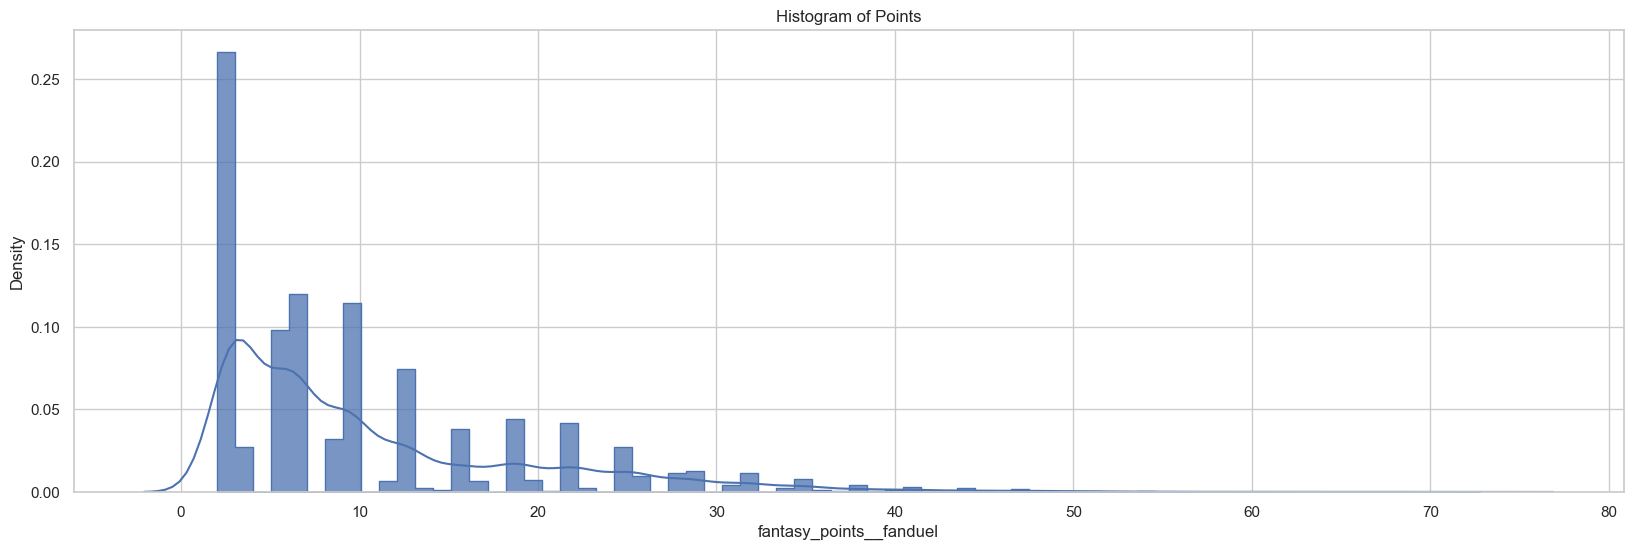

In [133]:
# Setting up style for better visualization
sns.set(style="whitegrid")

# Plotting the histogram
fig, ax = plt.subplots(figsize=(20, 6))

sns.kdeplot(
    data=catchers_df, 
    x='fantasy_points__fanduel',  
    common_norm=False,
    ax=ax
)

sns.histplot(
    data=catchers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=ax
)

ax.set_title('Histogram of Points')

plt.show()

### Adding more variables for categorizing players and don't assume a general distribution

In [134]:
statistics_by_catcher = catchers_df\
.groupby('player_info__player_id')\
.agg(number_of_observations=pd.NamedAgg("player_info__player_id", "count"))\
.sort_values(by=['number_of_observations'])\
.pipe(lambda df: df.assign(
    cumsum_observations=df.number_of_observations.cumsum(), 
    total_observations=df.number_of_observations.sum()
))\
.pipe(lambda df: df.assign(
    cumulative_proportion=(df.cumsum_observations / df.total_observations) * 100))\
.reset_index()\
.pipe(lambda df: df.assign(
    decile_group=pd.cut(df.cumulative_proportion, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype("str")
))

In [135]:
catchers_df = catchers_df.merge(right=statistics_by_catcher)

In [136]:
catchers_df.head()

,game_info__bigdataball_dataset,game_info__game_id,game_info__date,player_info__player_id,player_info__player_name,player_info__team,player_info__opponent,player_info__venue,position__draftkings,position__fanduel,...,fantasy_points__draftkings,fantasy_points__fanduel,fantasy_points__yahoo,game_info__game_type,year,number_of_observations,cumsum_observations,total_observations,cumulative_proportion,decile_group
0,MLB 2022 Regular Season,44679-SDP@CIN-1,2022-04-28,595751.0,Jorge Alfaro,San Diego Padres,Cincinnati Reds,Road,C,C,...,9.0,13.0,9.0,regular-season,2022,208,8574,12915,66.387921,"(60, 70]"
1,MLB 2022 Regular Season,44686-MIA@SDP-1,2022-05-05,595751.0,Jorge Alfaro,San Diego Padres,Miami Marlins,Home,C,C,...,5.0,6.0,5.2,regular-season,2022,208,8574,12915,66.387921,"(60, 70]"
2,MLB 2022 Regular Season,44689-MIA@SDP-1,2022-05-08,595751.0,Jorge Alfaro,San Diego Padres,Miami Marlins,Home,NaN,C,...,NaN,25.7,18.0,regular-season,2022,208,8574,12915,66.387921,"(60, 70]"
3,MLB 2022 Regular Season,44692-CHC@SDP-1,2022-05-11,595751.0,Jorge Alfaro,San Diego Padres,Chicago Cubs,Home,NaN,C,...,NaN,3.0,2.6,regular-season,2022,208,8574,12915,66.387921,"(60, 70]"
4,MLB 2022 Regular Season,44695-SDP@ATL-1,2022-05-14,595751.0,Jorge Alfaro,San Diego Padres,Atlanta Braves,Road,NaN,C,...,NaN,12.7,9.0,regular-season,2022,208,8574,12915,66.387921,"(60, 70]"


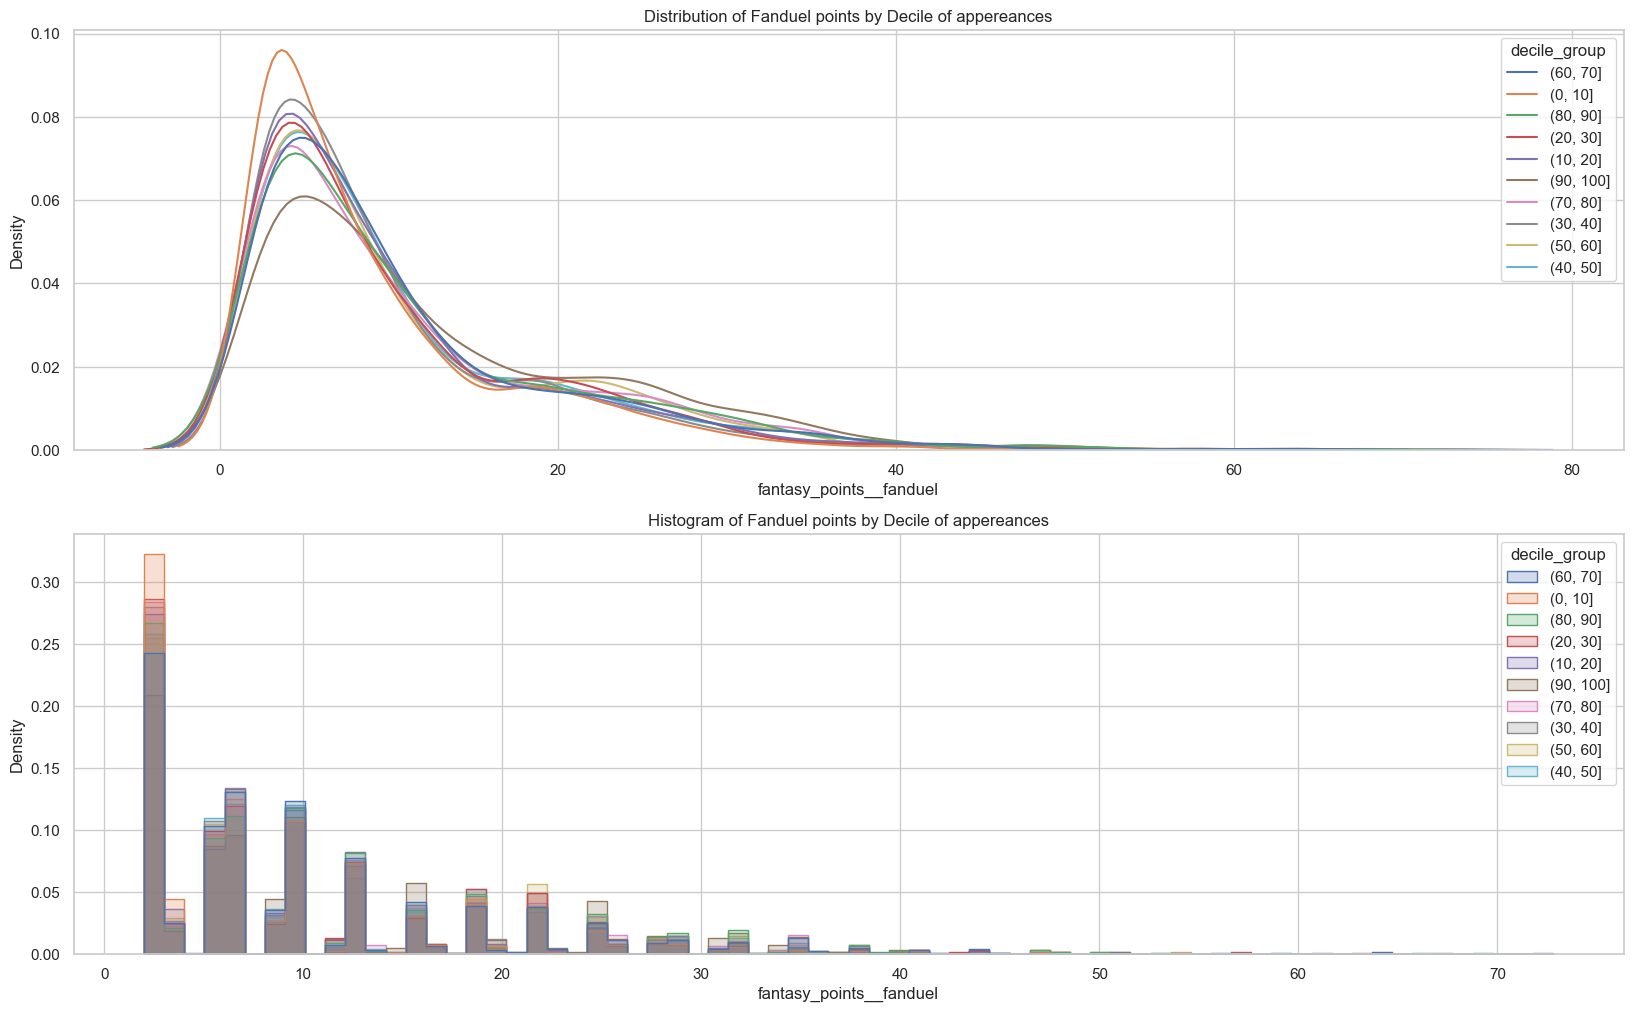

In [137]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 12))

sns.kdeplot(
    data=catchers_df, 
    x='fantasy_points__fanduel', 
    hue='decile_group', 
    common_norm=False,
    ax=ax[0],
)

ax[0].set_title('Distribution of Fanduel points by Decile of appereances')

sns.histplot(
    data=catchers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    hue='decile_group', 
    common_norm=False,
    ax=ax[1]
)

ax[1].set_title('Histogram of Fanduel points by Decile of appereances')

plt.show()

### Fitting a general distribution

In [138]:
data = catchers_df['fantasy_points__fanduel']

#### Fitting

In [139]:
catchers_distribution_fitter = DistributionFitter(
    distributions=[dist for dist in get_distributions() if dist not in ["levy_stable", "studentized_range", "erlang", "lognorm", "loguniform"]], 
    bins=sturges_bins(data)
)

In [140]:
catchers_distribution_fitter.fit(data)

INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: alpha
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: anglit
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: arcsine
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: argus
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: beta
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: betaprime
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: bradford
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: burr
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: burr12
/opt/miniconda3/envs/statisti

#### Results

In [141]:
catchers_distribution_fitter.summary(sort_by="ks_statistic", top_n=15)

,distribution,squared_error,aic,bic,kullberg_divergence,ks_statistic,ks_p_value,fitted_params
genexpon,genexpon,0.249999,1432.979113,1470.309837,inf,0.135097,4.885196e-206,"{'a': 1.3306149408781775e-07, 'b': 0.002900198..."
exponpow,exponpow,0.248402,1659.995652,1682.394086,inf,0.138983,4.344815e-218,"{'b': 0.7036701229067095, 'loc': 1.99999999999..."
nakagami,nakagami,0.249316,1625.110249,1647.508684,inf,0.142033,8.629275e-228,"{'nu': 0.35175294245061656, 'loc': 1.999999999..."
chi,chi,0.249313,1626.691553,1649.089987,inf,0.144746,1.336261e-236,"{'df': 0.7094917112039218, 'loc': 1.9999999999..."
halfcauchy,halfcauchy,0.241304,1271.245311,1286.177601,inf,0.146890,1.110636e-243,"{'loc': 1.9999999990417248, 'scale': 5.1331599..."
halfgennorm,halfgennorm,0.240948,1382.958449,1405.356883,inf,0.147360,3.000658e-245,"{'beta': 0.8684138348907307, 'loc': 1.99999999..."
foldcauchy,foldcauchy,0.241401,1273.560773,1295.959207,inf,0.147537,7.694748e-246,"{'c': 0.09286448773487138, 'loc': 1.9999999999..."
truncpareto,truncpareto,0.241184,1367.211005,1397.075584,inf,0.152185,1.254701e-261,"{'b': 10.777077083542993, 'c': 1.8222511494800..."
weibull_min,weibull_min,0.241911,1409.466802,1431.865236,inf,0.152308,4.725877e-262,"{'c': 0.9705654703050375, 'loc': 1.99999999999..."
beta,beta,0.243193,1469.809477,1499.674056,inf,0.152613,4.187031e-263,"{'a': 0.9193468100379247, 'b': 13.909489170674..."


#### Validation

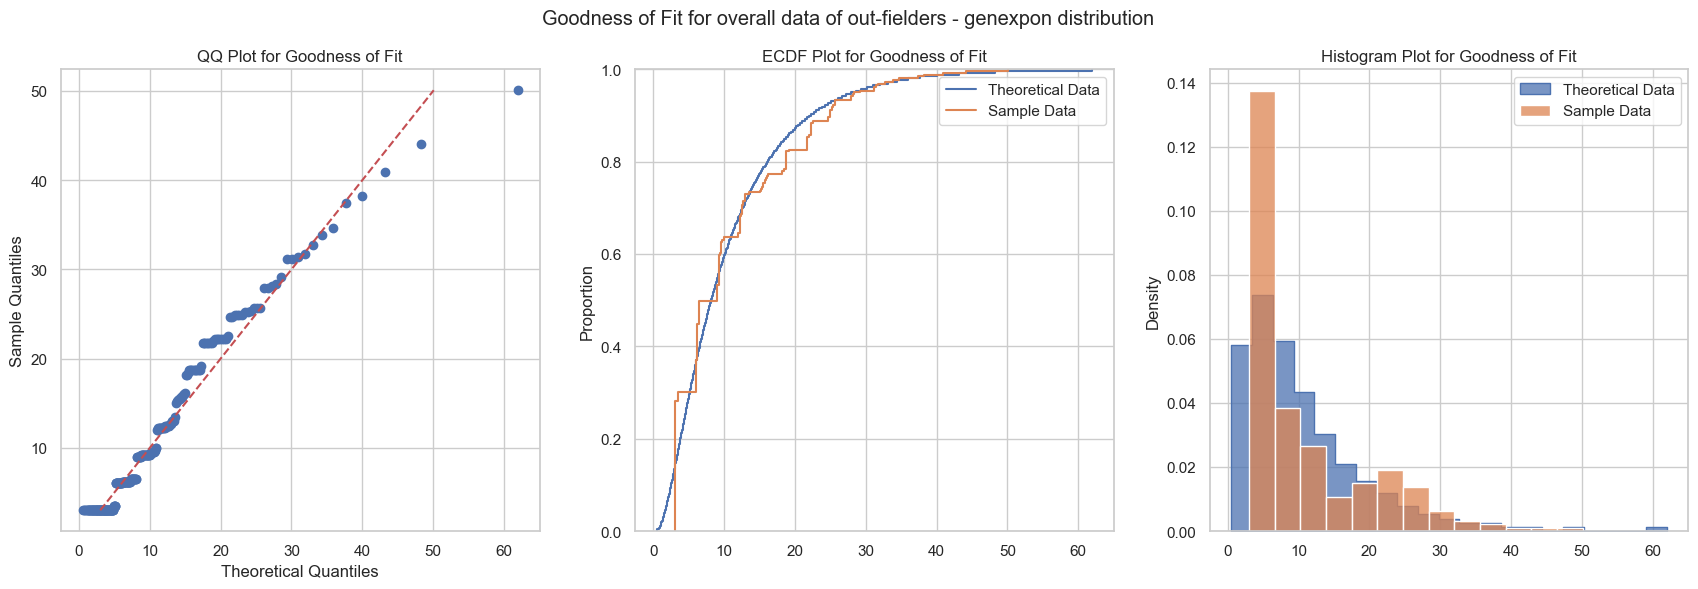

In [142]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=catchers_distribution_fitter, 
    distribution_name="genexpon", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - genexpon distribution"
)

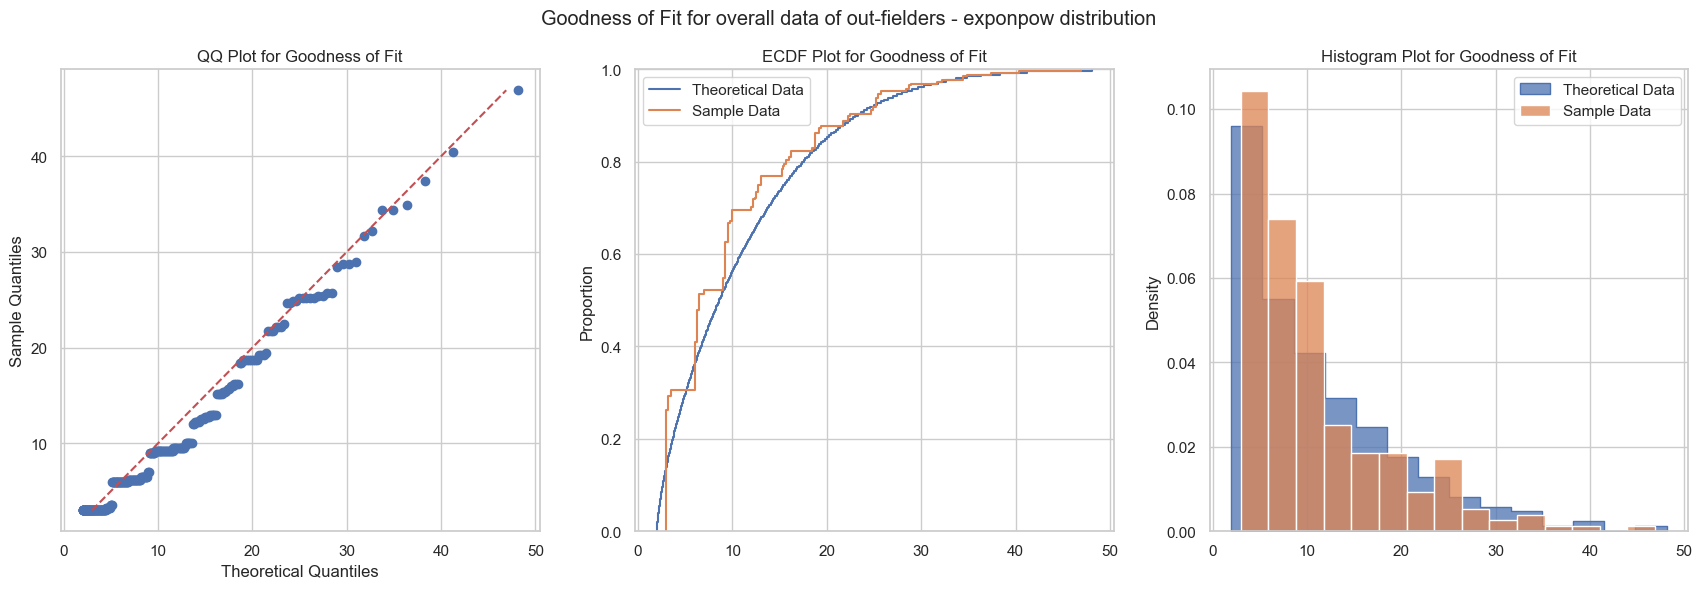

In [145]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=catchers_distribution_fitter, 
    distribution_name="exponpow", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - exponpow distribution"
)

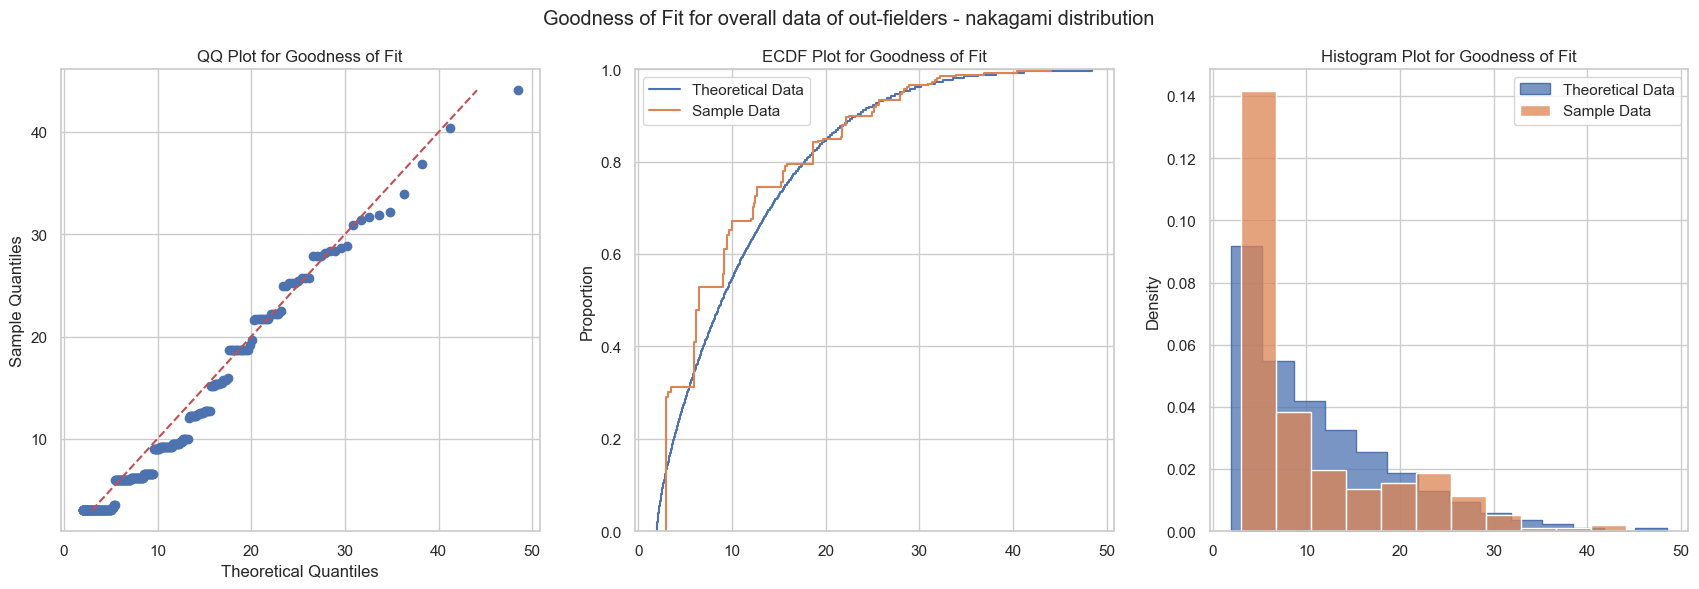

In [146]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=catchers_distribution_fitter, 
    distribution_name="nakagami", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - nakagami distribution"
)

### SS - Shortstop

In [154]:
shortstoppers_df = cleaned_mlb_df[
    (cleaned_mlb_df.position__fanduel == "SS") & 
    (~cleaned_mlb_df['fantasy_points__fanduel'].isna())
    ]

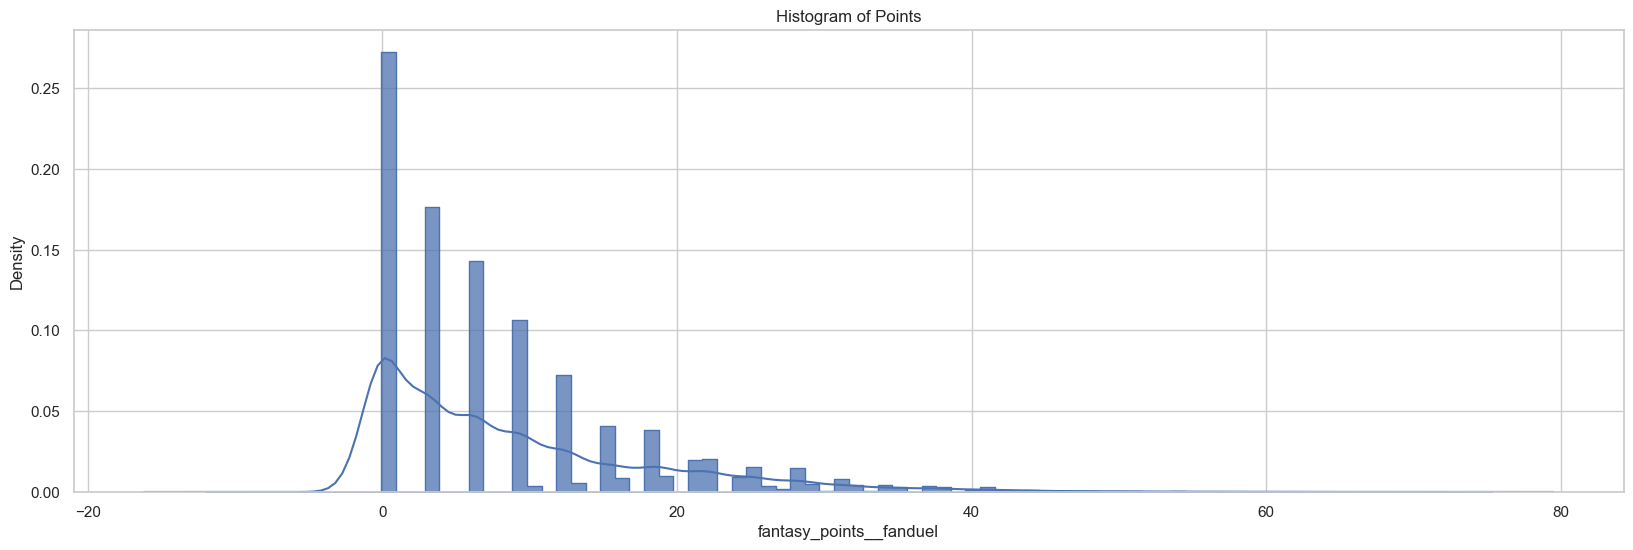

In [155]:
# Setting up style for better visualization
sns.set(style="whitegrid")

# Plotting the histogram
fig, ax = plt.subplots(figsize=(20, 6))

sns.kdeplot(
    data=shortstoppers_df, 
    x='fantasy_points__fanduel',  
    common_norm=False,
    ax=ax
)

sns.histplot(
    data=shortstoppers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=ax
)

ax.set_title('Histogram of Points')

plt.show()

### Fitting a general distribution

In [157]:
data = shortstoppers_df[(shortstoppers_df['fantasy_points__fanduel'] > 0)]['fantasy_points__fanduel']

#### Fitting

In [158]:
shortstoppers_distribution_fitter = DistributionFitter(
    distributions=[dist for dist in get_distributions() if dist not in ["levy_stable", "studentized_range", "erlang", "lognorm", "loguniform"]], 
    bins=sturges_bins(data)
)

In [159]:
shortstoppers_distribution_fitter.fit(data)

INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: alpha
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: anglit
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: arcsine
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: argus
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: beta
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: betaprime
INFO:statis

#### Results

In [160]:
shortstoppers_distribution_fitter.summary(sort_by="ks_statistic", top_n=15)

,distribution,squared_error,aic,bic,kullberg_divergence,ks_statistic,ks_p_value,fitted_params
weibull_min,weibull_min,0.164905,1369.813113,1391.836166,inf,0.108974,2.581289e-118,"{'c': 1.221591976891887, 'loc': 0.999629912221..."
burr12,burr12,0.164749,1343.539101,1372.903172,inf,0.109649,8.778821e-120,"{'c': 1.313709991138205, 'd': 10.2382742388094..."
ncx2,ncx2,0.164403,1346.743026,1376.107097,inf,0.113283,7.566535e-128,"{'df': 2.840267790186707, 'nc': 0.610994972694..."
foldcauchy,foldcauchy,0.167271,1179.910708,1201.933761,inf,0.113592,1.517874e-128,"{'c': 1.010490918370885, 'loc': 0.999999959558..."
beta,beta,0.164391,1357.006854,1386.370925,inf,0.114743,3.668143e-131,"{'a': 1.4514095337102617, 'b': 114.40497693061..."
gamma,gamma,0.164358,1347.686485,1369.709538,inf,0.115343,1.545225e-132,"{'a': 1.4683582919100973, 'loc': 0.99901648733..."
pearson3,pearson3,0.164358,1347.688732,1369.711785,inf,0.115343,1.545126e-132,"{'skew': 1.6504925853025538, 'loc': 11.9181652..."
chi2,chi2,0.164358,1347.684401,1369.707455,inf,0.115347,1.516626e-132,"{'df': 2.9367560997150335, 'loc': 0.9990162411..."
gibrat,gibrat,0.161257,1192.107896,1206.789931,inf,0.115949,6.209268e-134,"{'loc': 0.9903466581470046, 'scale': 7.4991087..."
gompertz,gompertz,0.167730,1772.238927,1794.261981,inf,0.121878,5.575968e-148,"{'c': 1.7258246631446927, 'loc': 0.99999999487..."


#### Validation

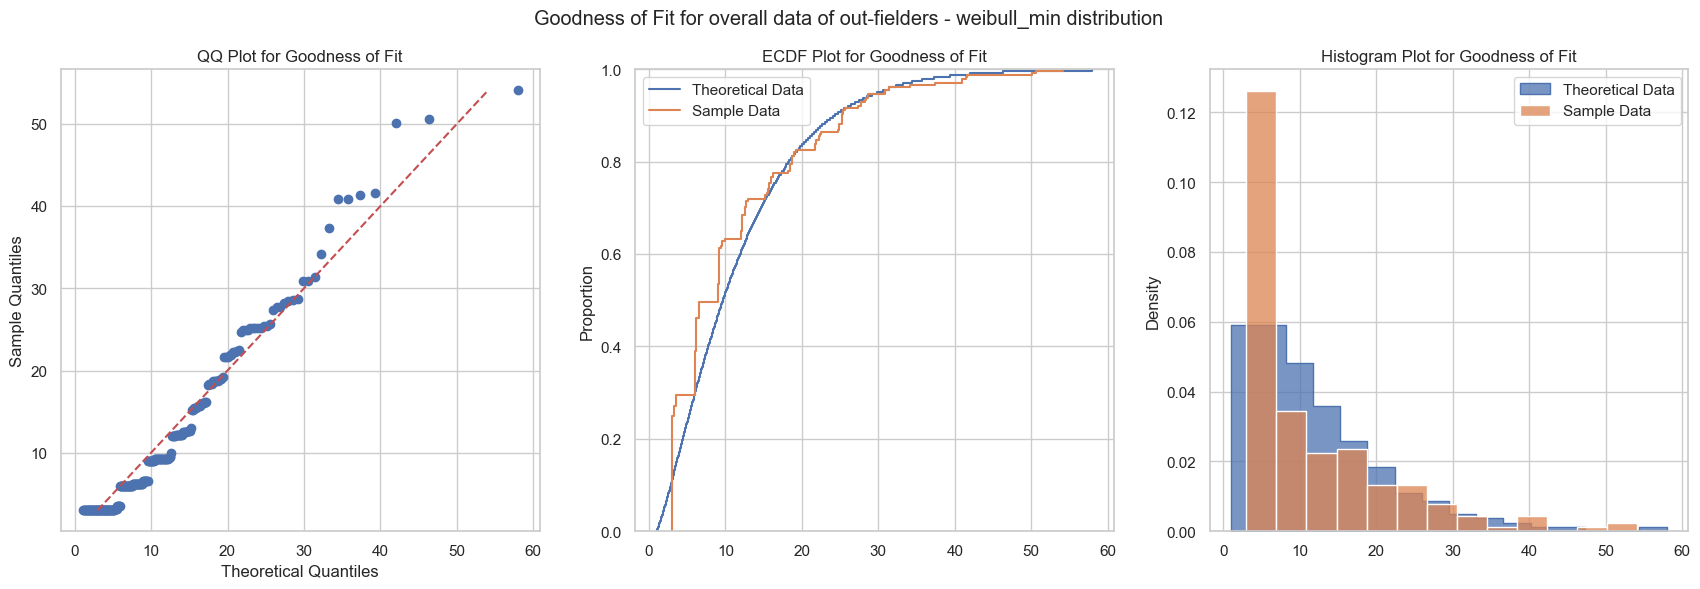

In [161]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=shortstoppers_distribution_fitter, 
    distribution_name="weibull_min", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - weibull_min distribution"
)

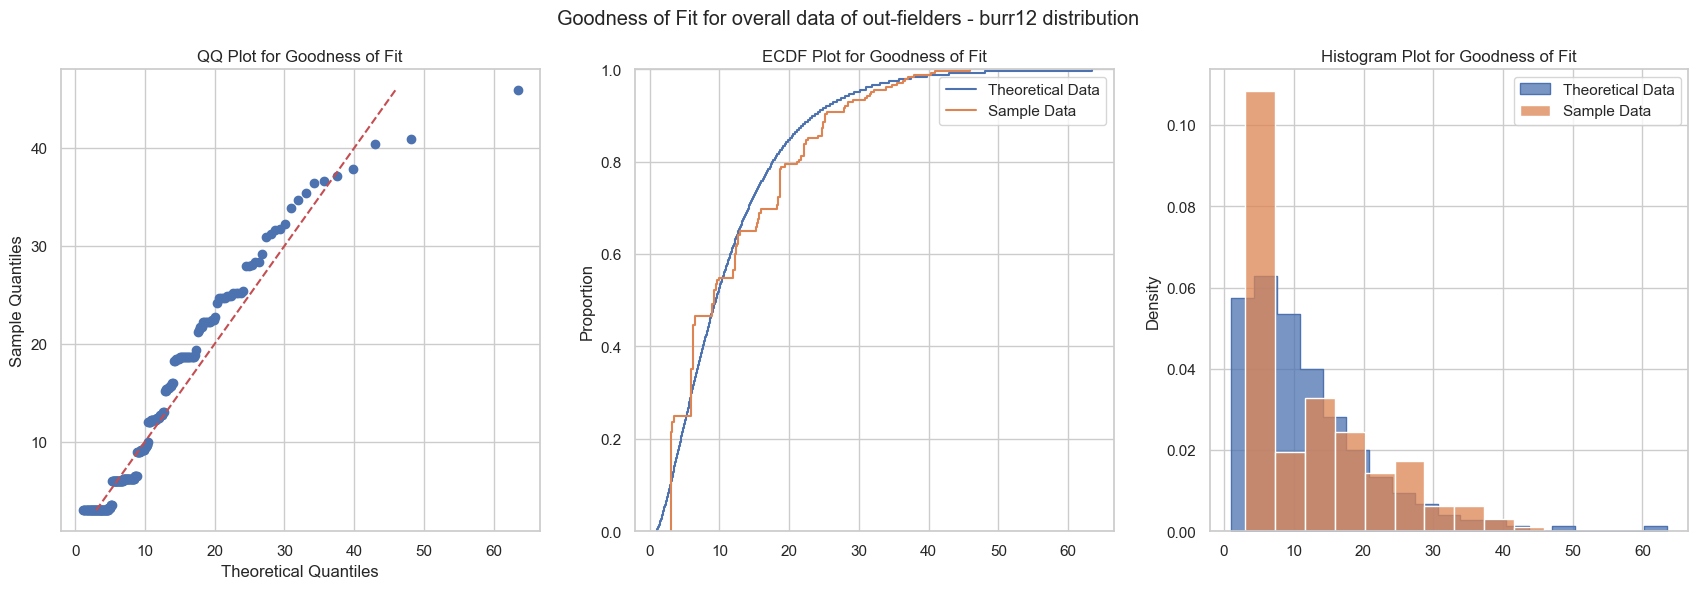

In [162]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=shortstoppers_distribution_fitter, 
    distribution_name="burr12", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - burr12 distribution"
)

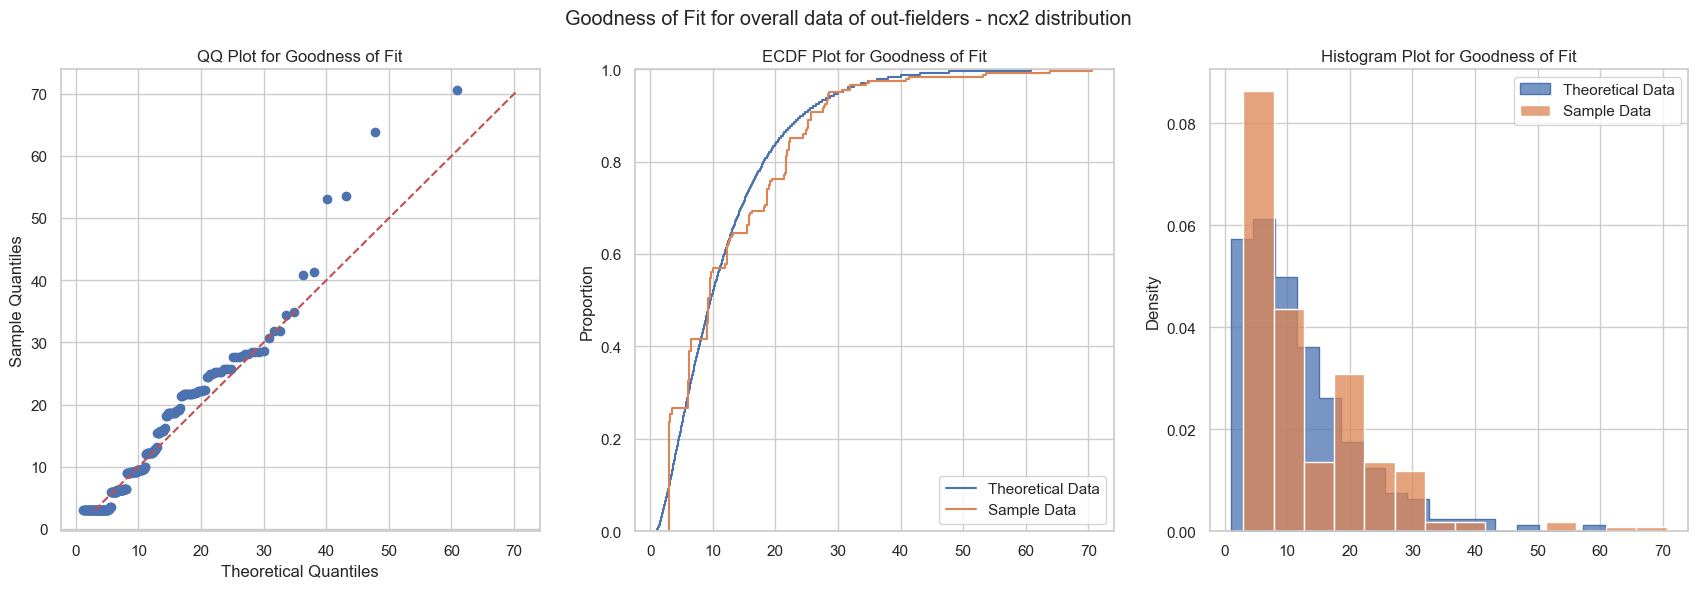

In [163]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=shortstoppers_distribution_fitter, 
    distribution_name="ncx2", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - ncx2 distribution"
)

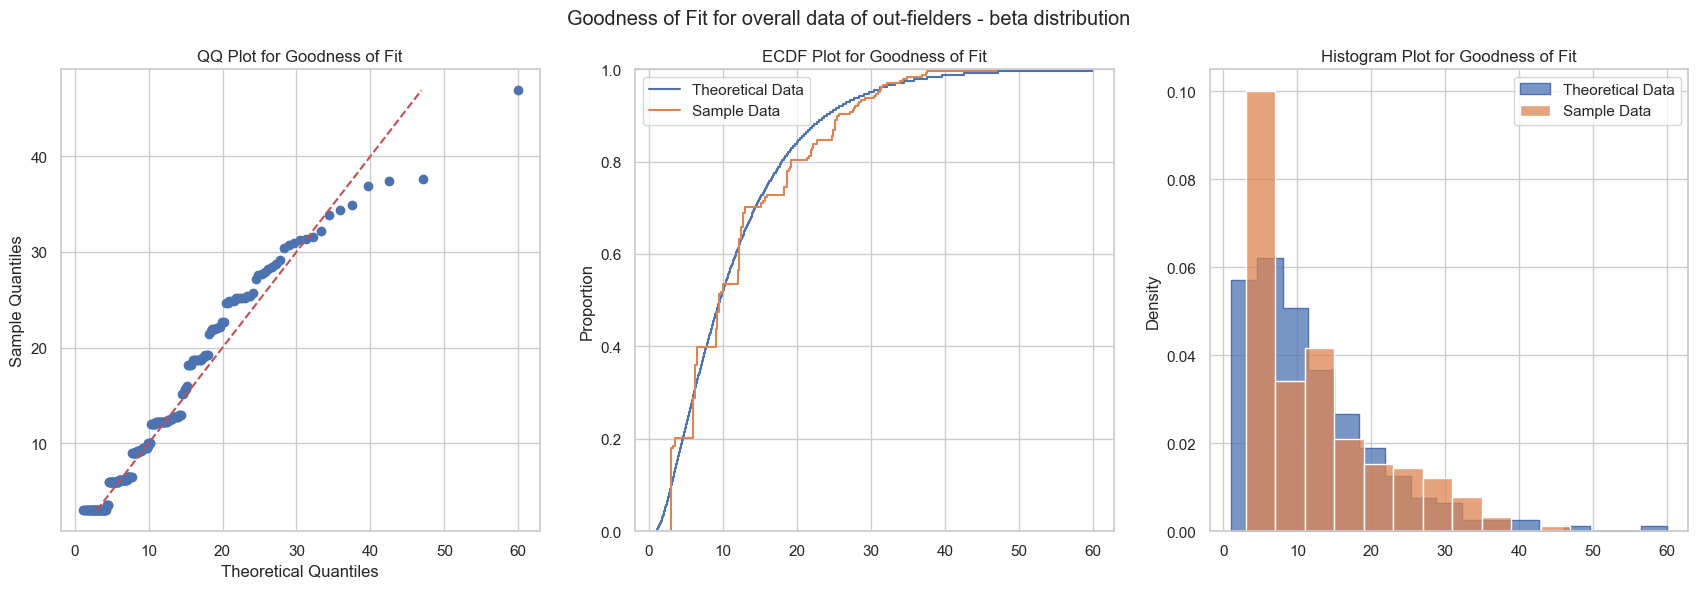

In [165]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=shortstoppers_distribution_fitter, 
    distribution_name="beta", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - beta distribution"
)